# Predicting Wins/Losses

This sections focuses on predicting wins and losses for NBA teams. Our final goal was to predict spreads, but we wanted to see how accurate we could predict wins or losses, with a goal of >60% to be significantly higher than that of a coin flip. 

**Data Preprocessing / Feature Engineering**

In [ ]:
import requests
import datetime
import pandas as pd
from bs4 import BeautifulSoup

# Coded by Austin Fett
month = {
    "January": 1,
    "February": 2,
    "March": 3,
    "April": 4,
    "May": 5,
    "June": 6,
    "July": 7,
    "August": 8,
    "September": 9,
    "October": 10,
    "November": 11,
    "December": 12
}

refTable = {
    "NY" : "NYK",
    "UTAH" : "UTA",
    "NO" : "NOP",
    "SA" : "SAS",
    "GS" : "GSW",
    "WSH" : "WAS"
}

# Gets games from certain range of espn gameids
def getGames():
  games = []
  checker = False

  # espn gameid range for 2023 season for all games including 2023-2-27
  # 401468016, 401468029
  # 401468170, 401469077
  # espn gameid range for all games in 2022 season
  # 401358773, 401358785
  # 401359833, 401361049
  # espn gameid range for all games in 2021 season
  # 401266805, 401266806
  # 401267150, 401267718
  # 401307309, 401307891

  for i in range(401540753, 401540780+1):
    URL = "https://www.espn.com/nba/boxscore/_/gameId/" + str(i)
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, "html.parser")

    g = getOdds(soup)
    
    # Prints out gameid ranges which are useful
    if g != None:
      if not checker:
        print('[', i)
      games.append(g)
      checker = True
    elif checker:
      print(i - 1, ']')
      checker = False
    
  return games

# Gets odds of specific game given soup content of espn page
def getOdds(soup):
  results = soup.find(class_="n8 GameInfo__Meta")

  # Return none if page is empty
  if results is None:
    return None
  
  # Gets date of game
  date_list = results.text.split(" ")
  date = datetime.datetime(int(date_list[4][:4]), int(month[date_list[2]]), int(date_list[3][:-1]))
  date_string = date.strftime("%Y-%m-%d")

  # Gets name of teams that played
  results = soup.find_all(class_="ScoreCell__Truncate Gamestrip__Truncate h4 clr-gray-01")
  away = results[0].find('a', href=True)['href'].split("/")[-2].upper()
  home = results[1].find('a', href=True)['href'].split("/")[-2].upper()

  # Changes team initials if needed for conversion
  a = refTable.get(away)
  if a is None:
    a = away
  h = refTable.get(home)
  if h is None:
    h = home

  results = soup.find(class_="betting-details-with-logo")

  # Return none if game was not played
  if results is not None:
    odds = results.find_all('div')
    line = odds[0].text.split(' ')
    overunder = odds[1].text.split(' ')
  else:
    return None

  # Gets line for game, 0 point spread if even
  if len(line) < 3:
    l = [home, "0"]
  else:
    l = line[1:]

  # Gets favorite of game
  fav = refTable.get(l[0])
  if fav is None:
    fav = l[0]
  
  line_string = fav + " " + l[1]

  # Formats overunder
  if float(overunder[1]) % 1 == 0:
    o = int(overunder[1])
  else:
    o = float(overunder[1])

  return ([date_string, a, h, fav, l[1], o])

# Gets game lines and transforms into a csv file
def getOddsCSV():
  games = getGames()
  games_lines_df = pd.DataFrame(games)
  games_lines_df = games_lines_df.rename(columns={0: 'Date', 1: 'Away', 2: 'Home', 3: 'Favorite', 4: 'Line', 5: 'Over/Under'})
  games_lines_df.to_csv('2021_Season_Odds.csv')

getOddsCSV()

[ 401540753
401540757 ]


These next two sections are pulling in the season average data to be used to predict wins and losses. The averages are then combined with the vegas lines pulled from ESPN. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Pulls box scores from PBP stats CSV files. The averages for each game throughout
## the season up to that game are then calculated and added into the dataframe at that date.
## This data will be used as testing data in our later models.
## Pulls box scores from PBP stats CSV files. The averages for each game throughout
## the season up to that game are then calculated and added into the dataframe at that date.
## This data will be used as testing data in our later models.
## Coded by Austin Fett
def get_box_score_average_data():

  # For future use, we will be pulling in all teams data
  team_list = ["Atl", "Bkn", "Bos", "Cha", "Chi", "Cle", "Dal", "Den", "Det", "Gsw", "Hou", "Ind", "Lac", 
              "Lal", "Mem", "Mia", "Mil", "Min", "Nop", "Nyk", "Okc", "Orl", "Phi", "Phx", "Por", "Sac", 
              "Sas", "Tor", "Uta", "Was"]
  
  # Currently dealing with the Atlanta Hawks data over the last many seasons. 
  team = "Atl"

  # CSV files are currently stored in a github that allows us to easily access the CSV files from coLab
  team_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Box_Score.csv'
  opp_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Opp_Box_Score.csv'

  # Read the CSV files
  team_data = pd.read_csv(team_file)
  opp_data = pd.read_csv(opp_file)

  # This is going to be more important in the future, but this csv files contains all of the season odds
  # Up to this point in the sesason. 
  game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023_Season_Odds.csv'
  game_lines_2023_data = pd.read_csv(game_lines_2023_file)

  # Features that will be looked at in models
  stat_list = ["OffPoss", "Points", "FG2M", "FG2A", "Fg2Pct", "FG3M", "FG3A", "Fg3Pct", "NonHeaveFg3Pct", 
              "FtPoints", "PtsAssisted2s", "PtsUnassisted2s", "PtsAssisted3s", "PtsUnassisted3s",
              "Assisted2sPct", "NonPutbacksAssisted2sPct", "Assisted3sPct", "FG3APct", "ShotQualityAvg", "EfgPct",
              "TsPct", "PtsPutbacks", "Fg2aBlocked", "FG2APctBlocked", "Fg3aBlocked", "FG3APctBlocked"]

  # Initializing list of dicts
  rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]
  average_rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]
  averageL5_rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]

  # Initialize dataframes that will be used to hold features (statistical information)
  for i in team_data.index:
    d1 = {}
    d2 = {}
    d3 = {}

    for stat in stat_list:
      d1[stat] = ''
      d2[stat] = ''
      d3[stat] = ''

    for stat in stat_list:
      d1['Opp_' + stat] = ''
      d2['Opp_' + stat] = ''
      d3['Opp_' + stat] = ''

    rows.append(d1)
    average_rows.append(d2)
    averageL5_rows.append(d3)

  result_found = []

  for i in team_data.index:
    result_found.append(False)

  # Go through csv and populate stat values
  index = 0

  # For each feature that will be used, we will loop through the csv files and grab the necessary
  # statistical information
  for stat in stat_list:
    sum_team = 0
    sum_opp = 0

    # Loop through team data
    for i in team_data.index:
      # Ensures to only add certain data once
      if not result_found[i]:
        # Loop through game lines to find correct line
        for j in range(len(game_lines_2023_data.index)):
          if game_lines_2023_data["Date"][j] == team_data["Date"][i]:
            away = game_lines_2023_data["Away"][j]
            home = game_lines_2023_data["Home"][j]
            
            if away == team.upper():
              rows[i]["Home"] = home
              rows[i]["Away"] = away
              index = j
              break
            elif home == team.upper():
              rows[i]["Home"] = home
              rows[i]["Away"] = away
              index = j
              break
        
        # Saves date of game
        rows[i]["Date"] = game_lines_2023_data["Date"][index]
        average_rows[i]["Date"] = game_lines_2023_data["Date"][index]
        averageL5_rows[i]["Date"] = game_lines_2023_data["Date"][index]

        # Adds 1 for win, 0 for loss
        if (team_data["Points"][i] - opp_data["Points"][i] > 0):
          average_rows[i]["won"] = 1
          averageL5_rows[i]["won"] = 1
        else:
          average_rows[i]["won"] = 0
          averageL5_rows[i]["won"] = 0
        
        rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]
        average_rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]

        # Adds spread result of difference between favorite covering and the spread
        if game_lines_2023_data["Favorite"][index] == team.upper():
          if (team_data["Points"][i] - opp_data["Points"][i]) != -float(game_lines_2023_data["Line"][index]):
            rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            average_rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            averageL5_rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
          else:
            rows[i]["Spread_Result"] = 0
            average_rows[i]["Spread_Result"] = 0
            averageL5_rows[i]["Spread_Result"] = 0
        else:
          if (opp_data["Points"][i] - team_data["Points"][i]) != -float(game_lines_2023_data["Line"][index]):
            rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            average_rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            averageL5_rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
          else:
            rows[i]["Spread_Result"] = 0
            average_rows[i]["Spread_Result"] = 0
            averageL5_rows[i]["Spread_Result"] = 0

        # Adds over/under result of difference between total score and the line
        if (team_data["Points"][i] + opp_data["Points"][i]) != float(game_lines_2023_data["Over/Under"][index]):
          rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
          average_rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
          averageL5_rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
        else:
          rows[i]["O/U_Result"] = 0
          average_rows[i]["O/U_Result"] = 0
          averageL5_rows[i]["O/U_Result"] = 0

        result_found[i] = True

      sum_team += team_data[stat][i]
      sum_opp += opp_data[stat][i]

      # Adds the stats
      rows[i][stat] = team_data[stat][i]
      rows[i]['Opp_' + stat] = opp_data[stat][i]

      # Averages the stats of all games up to now, adding it for the next game
      if i != len(team_data.index):
        average_rows[i + 1][stat] = sum_team / (i + 1)
        average_rows[i + 1]['Opp_' + stat] = sum_opp / (i + 1)

      # Averages the stats of the last 5 games
      sum_stat = 0
      sum_opp_stat = 0
      count = 0
      for j in range(1, 6):
        if i - j >= 0:
          sum_stat += team_data[stat][i - j]
          sum_opp_stat += opp_data[stat][i - j]
          count += 1

      if count != 0:
        averageL5_rows[i][stat] = sum_stat / count
        averageL5_rows[i]['Opp_' + stat] = sum_opp_stat / count

  Df = pd.DataFrame(rows[:-1])
  averageDf = pd.DataFrame(average_rows[:-1])
  averageL5Df = pd.DataFrame(averageL5_rows[:-1])
  averageDf = averageDf.dropna()
  wins = averageDf[['won']]
  averageDf = averageDf.drop('won', axis = 1)
  averageDf = averageDf.shift(periods = 1)
  averageDf['won'] = wins
  averageDf = averageDf.drop(1)
  return averageDf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Pulls box scores from PBP stats CSV files. The averages for each game throughout
## the season up to that game are then calculated and added into the dataframe at that date.
## This data will be used as testing data in our later models.
## Coded by Austin Fett
def get_box_score_average_data_1():

  # For future use, we will be pulling in all teams data
  team_list = ["Atl", "Bkn", "Bos", "Cha", "Chi", "Cle", "Dal", "Den", "Det", "Gsw", "Hou", "Ind", "Lac", 
              "Lal", "Mem", "Mia", "Mil", "Min", "Nop", "Nyk", "Okc", "Orl", "Phi", "Phx", "Por", "Sac", 
              "Sas", "Tor", "Uta", "Was"]

  ind = 0
  Df = []
  averageDf = []
  averageL5Df = []
  for team in team_list:
    # Currently dealing with the Atlanta Hawks data over the last many seasons. 

    # CSV files are currently stored in a github that allows us to easily access the CSV files from coLab
    team_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Box_Score_2021_2023.csv'
    opp_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Opp_Box_Score_2021_2023.csv'


    # Read the CSV files
    team_data = pd.read_csv(team_file)
    opp_data = pd.read_csv(opp_file)

    # This is going to be more important in the future, but this csv files contains all of the season odds
    # Up to this point in the sesason. 
    game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Season_Odds.csv'
    game_lines_2023_data = pd.read_csv(game_lines_2023_file)

    # Features that will be looked at in models
    stat_list = ["OffPoss", "Points", "FG2M", "FG2A", "Fg2Pct", "FG3M", "FG3A", "Fg3Pct", "NonHeaveFg3Pct", 
                "FtPoints", "PtsAssisted2s", "PtsUnassisted2s", "PtsAssisted3s", "PtsUnassisted3s",
                "Assisted2sPct", "NonPutbacksAssisted2sPct", "Assisted3sPct", "FG3APct", "ShotQualityAvg", "EfgPct",
                "TsPct", "PtsPutbacks", "Fg2aBlocked", "FG2APctBlocked", "Fg3aBlocked", "FG3APctBlocked"]

    # Initializing list of dicts
    rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]
    average_rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]
    averageL5_rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}]

    # Initialize dataframes that will be used to hold features (statistical information)
    for i in team_data.index:
      d1 = {}
      d2 = {}
      d3 = {}

      for stat in stat_list:
        d1[stat] = ''
        d2[stat] = ''
        d3[stat] = ''

      for stat in stat_list:
        d1['Opp_' + stat] = ''
        d2['Opp_' + stat] = ''
        d3['Opp_' + stat] = ''

      rows.append(d1)
      average_rows.append(d2)
      averageL5_rows.append(d3)

    result_found = []

    for i in team_data.index:
      result_found.append(False)

    # Go through csv and populate stat values
    index = 0

    # For each feature that will be used, we will loop through the csv files and grab the necessary
    # statistical information
    for stat in stat_list:
      sum_team = 0
      sum_opp = 0

      # Loop through team data
      for i in team_data.index:
        # Ensures to only add certain data once
        if not result_found[i]:
          # Loop through game lines to find correct line
          for j in range(len(game_lines_2023_data.index)):
            if game_lines_2023_data["Date"][j] == team_data["Date"][i]:
              away = game_lines_2023_data["Away"][j]
              home = game_lines_2023_data["Home"][j]
              
              if away == team.upper():
                rows[i]["Home"] = 0
                average_rows[i]["Home"] = 0
                averageL5_rows[i]["Home"] = 0
                index = j
                break
              elif home == team.upper():
                rows[i]["Home"] = 1
                average_rows[i]["Home"] = 1
                averageL5_rows[i]["Home"] = 1
                index = j
                break
          
          # Saves date of game
          rows[i]["Date"] = game_lines_2023_data["Date"][index]
          average_rows[i]["Date"] = game_lines_2023_data["Date"][index]
          averageL5_rows[i]["Date"] = game_lines_2023_data["Date"][index]

          # Adds 1 for win, 0 for loss
          if (team_data["Points"][i] - opp_data["Points"][i] > 0):
            rows[i]["won"] = 1
            average_rows[i]["won"] = 1
            averageL5_rows[i]["won"] = 1
          else:
            rows[i]["won"] = 0
            average_rows[i]["won"] = 0
            averageL5_rows[i]["won"] = 0
        
          rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]
          average_rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]
          averageL5_rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]

          # Adds spread result of difference between favorite covering and the spread
          if game_lines_2023_data["Favorite"][index] == team.upper():
            if (team_data["Points"][i] - opp_data["Points"][i]) != -float(game_lines_2023_data["Line"][index]):
              rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
              average_rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
              averageL5_rows[i]["Spread_Result"] = float(team_data["Points"][i]) - float(opp_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            else:
              rows[i]["Spread_Result"] = 0
              average_rows[i]["Spread_Result"] = 0
              averageL5_rows[i]["Spread_Result"] = 0
          else:
            if (opp_data["Points"][i] - team_data["Points"][i]) != -float(game_lines_2023_data["Line"][index]):
              rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
              average_rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
              averageL5_rows[i]["Spread_Result"] = float(opp_data["Points"][i]) - float(team_data["Points"][i]) + float(game_lines_2023_data["Line"][index])
            else:
              rows[i]["Spread_Result"] = 0
              average_rows[i]["Spread_Result"] = 0
              averageL5_rows[i]["Spread_Result"] = 0

          # Adds over/under result of difference between total score and the line
          if (team_data["Points"][i] + opp_data["Points"][i]) != float(game_lines_2023_data["Over/Under"][index]):
            rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
            average_rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
            averageL5_rows[i]["O/U_Result"] = float(team_data["Points"][i]) + float(opp_data["Points"][i]) - float(game_lines_2023_data["Over/Under"][index])
          else:
            rows[i]["O/U_Result"] = 0
            average_rows[i]["O/U_Result"] = 0
            averageL5_rows[i]["O/U_Result"] = 0

          result_found[i] = True

        sum_team += team_data[stat][i]
        sum_opp += opp_data[stat][i]

        # Adds the stats
        rows[i][stat] = team_data[stat][i]
        rows[i]['Opp_' + stat] = opp_data[stat][i]

        # Averages the stats of all games up to now, adding it for the next game
        if i != len(team_data.index):
          average_rows[i + 1][stat] = sum_team / (i + 1)
          average_rows[i + 1]['Opp_' + stat] = sum_opp / (i + 1)

        # Averages the stats of the last 5 games
        sum_stat = 0
        sum_opp_stat = 0
        count = 0
        for j in range(1, 6):
          if i - j >= 0:
            sum_stat += team_data[stat][i - j]
            sum_opp_stat += opp_data[stat][i - j]
            count += 1

        if count != 0:
          averageL5_rows[i][stat] = sum_stat / count
          averageL5_rows[i]['Opp_' + stat] = sum_opp_stat / count
    
    
    tempDf = pd.DataFrame(rows[:-1])
    Df.append(tempDf)
    tempAverageDf = pd.DataFrame(average_rows[:-1])
    tempAverageL5Df = pd.DataFrame(averageL5_rows[:-1])
    tempAverageDf = tempAverageDf.dropna()
    # wins = tempAverageDf[['won']]
    # home = tempAverageDf[['Home']]
    # tempAverageDf = tempAverageDf.drop('won', axis = 1)
    # tempAverageDf = tempAverageDf.drop('Home', axis = 1)
    # tempAverageDf = tempAverageDf.shift(periods = 1)
    # tempAverageDf['won'] = wins
    # tempAverageDf['Home'] = home
    
    # tempAverageDf = tempAverageDf.drop(1)
    averageDf.append(tempAverageDf)
    averageL5Df.append(tempAverageL5Df)

    ind = ind + 1

  return averageDf, Df, averageL5Df

In [ ]:
averageData, boxScoreData, l5Data = get_box_score_average_data_1()

In [ ]:
##This combines the boxscoredata to be one single dataframe and drops the nulls, we do
##this for all of the dataframes returned 
combinedBox = pd.concat(boxScoreData)
combinedBox = combinedBox.dropna()

averageDataCombined = pd.concat(averageData)
averageDataCombined = averageDataCombined.dropna()

lastFive = pd.concat(l5Data)
lastFive = lastFive.dropna()

6394

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
## This function is very similar to the above function grabbing average data, it is
## just returning a different dataframe without the data and using different files.
## These two function will be combined, but due to people working seperate ideas at the same
## time, we decided to leave both in at the moment so we didn't ruin anyone's current work.

#Coded by Austin Fett
def get_box_score_train_data():

  team_list = ["Atl", "Bkn", "Bos", "Cha", "Chi", "Cle", "Dal", "Den", "Det", "Gsw", "Hou", "Ind", "Lac", 
             "Lal", "Mem", "Mia", "Mil", "Min", "Nop", "Nyk", "Okc", "Orl", "Phi", "Phx", "Por", "Sac", 
             "Sas", "Tor", "Uta", "Was"]

  team = "ATL"

  team_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Box_Score_4_Years.csv'
  opp_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/' + team + '_Box_Score_Opp_4_Years.csv'
  team_data = pd.read_csv(team_file)
  opp_data = pd.read_csv(opp_file)

  stat_list = ["OffPoss", "Points", "FG2M", "FG2A", "Fg2Pct", "FG3M", "FG3A", "Fg3Pct", "NonHeaveFg3Pct", 
            "FtPoints", "PtsAssisted2s", "PtsUnassisted2s", "PtsAssisted3s", "PtsUnassisted3s",
            "Assisted2sPct", "NonPutbacksAssisted2sPct", "Assisted3sPct", "FG3APct", "ShotQualityAvg", "EfgPct",
            "TsPct", "PtsPutbacks", "Fg2aBlocked", "FG2APctBlocked", "Fg3aBlocked", "FG3APctBlocked"]

  # Initializing list of dicts
  rows = [{"Date": ''}]
  for i in team_data.index:
    d1 = {}
    d2 = {}

    for stat in stat_list:
      d1[stat] = ''
      d2[stat] = ''

    for stat in stat_list:
      d1['Opp_' + stat] = ''
      d2['Opp_' + stat] = ''

    rows.append(d1)

  result_found = []
  for i in team_data.index:
    result_found.append(False)

  # Go through csv and populate stat values
  index = 0
  for stat in stat_list:
    sum_team = 0
    sum_opp = 0

    for i in team_data.index:    
      if not result_found[i]:
        
        rows[i]["Date"] = opp_data["Date"][index]
      
        if (team_data["Points"][i] - opp_data["Points"][i] > 0):
              rows[i]["won"] = 1
        else:
          rows[i]["won"] = 0

        rows[i]["PointDifference"] = opp_data["Points"][i] - team_data["Points"][i]
          
        result_found[i] = True

      sum_team += team_data[stat][i]
      sum_opp += opp_data[stat][i]
      
      rows[i][stat] = team_data[stat][i]
      rows[i]['Opp_' + stat] = opp_data[stat][i]
      rows[i][stat + '_diff'] = team_data[stat][i] - opp_data[stat][i]
      
  Df = pd.DataFrame(rows[:-1])
  Df = Df.dropna()
  Df = Df[['Date', 'won', 'PointDifference', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
              'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
              'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
              'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
              'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]
  return Df

In [ ]:
## From the notes in assignment 2
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train, testData = split_train_test(averageDataCombined, .2)


**Split Train/Test Data**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.layers import LSTM

# This function splits the data in train and test data. The training data consists
# of data over the last 4 nba seasons, not including the current season. This data
# is solely box scores, with a column indicating whether the team won or not (1 or 0).
# The test set is the averages throughout the games played until that point in the set.
# There is also a column indicating whether the team won or not at that point in the season
# with those averages (1 or 0).

# Coded by Tyler Wulff
def classification_train_test_data():
  
  # Pull box score data from the last 4 seasons
  Df = combinedBox
  # Pull average box score data from the current season 
  averageDf = get_box_score_average_data()

  #Features used in the training data set and test set are the same
  x_train = Df[['Home', 'Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]

  #Label is 1 or 0 whether the team won (1) or lost (0)
  y_train = Df[['won']]

  x_test = testData[['Fg2Pct', 'Home', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]

  y_test = testData[['won']]

  return x_train, y_train, x_test, y_test


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.layers import LSTM
from sklearn import preprocessing

# This function splits the data in train and test data. The training data consists
# of data over the last 4 nba seasons, not including the current season. This data
# is solely box scores, with a column indicating whether the team won or not (1 or 0).
# The test set is the averages throughout the games played until that point in the set.
# There is also a column indicating whether the team won or not at that point in the season
# with those averages (1 or 0).

# Coded by Tyler Wulff
def classification_train_test_data_param(df):
  
  train, testData = split_train_test(df, .2)

  #Features used in the training data set and test set are the same
  x_train = train[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
              'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
              'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked']]

  x_train = x_train.values
  x_train = preprocessing.MinMaxScaler().fit_transform(x_train)
  x_train = pd.DataFrame(x_train)

  #Label is 1 or 0 whether the team won (1) or lost (0)
  y_train = train[['won']]

  x_test = testData[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
              'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
              'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked']]

  x_test = x_test.values
  x_test = preprocessing.MinMaxScaler().fit_transform(x_test)
  x_test = pd.DataFrame(x_test)
  
  y_test = testData[['won']]

  return x_train, y_train, x_test, y_test

def classification_train_test_data():
  
  # Pull box score data from the last 4 seasons
  Df = combinedBox[:5115]
  # Pull average box score data from the current season 
  averageDf = averageDataCombined[5115:]


  #Features used in the training data set and test set are the same
  x_train = Df[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]
  
  x_train = x_train.values
  x_train = preprocessing.MinMaxScaler().fit_transform(x_train)
  x_train = pd.DataFrame(x_train)
  #Label is 1 or 0 whether the team won (1) or lost (0)
  y_train = Df[['won']]

  x_test = averageDf[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]
  
  x_test = x_test.values
  x_test = preprocessing.MinMaxScaler().fit_transform(x_test)
  x_test = pd.DataFrame(x_test)

  y_test = averageDf[['won']]

  return x_train, y_train, x_test, y_test



In [ ]:
## This function splits the data in train and test data. The training data consists
## of data over the last 4 nba seasons, not including the current season. This data
## is solely box scores, with a column indicating how much the team won or lost by (PointDifference).
## The test set is the averages throughout the games played until that point in the set.
## There is also a column indicating by how much the team won or lost by with those averages
## at that point in the season. 

# Coded by Tyler Wulff
def regression_train_test_data():
  
  # Pull box score data from the last 4 seasons
  Df = combinedBox[:5115]
  # Pull average box score data from the current season 
  averageDf = averageDataCombined[5115:]

  # Initialize train set
  train_set = Df

  # Drop Label and Date in the x train set. Won will also be dropped as that is something
  # that won't be able to be used when predicting future games
  x_train = Df[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]

  x_train = x_train.values
  x_train = preprocessing.MinMaxScaler().fit_transform(x_train)
  x_train = pd.DataFrame(x_train)
  # PointDifference will be used as the label
  y_train = train_set[['PointDifference']]

  #Initialize the test_set with these featuers
  test_set = averageDf[['Home', 'Date', 'won', 'PointDifference', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'FG3APct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_FG3APct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]

  #Drop date, won, and PointDifference for same reaseons as above
  x_test = test_set.drop(columns = ['Date', 'won', 'PointDifference'])

  x_test = x_test.values
  x_test = preprocessing.MinMaxScaler().fit_transform(x_test)
  x_test = pd.DataFrame(x_test)
  #PointDifference will be label
  y_test = test_set[['PointDifference']]

  return x_train, y_train, x_test, y_test


def regression_train_test_data_param(df):
  
  train_set, test_set = split_train_test(df, .2)

  # Drop Label and Date in the x train set. Won will also be dropped as that is something
  # that won't be able to be used when predicting future games
  x_train = train_set[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]
  x_train = x_train.values
  x_train = preprocessing.MinMaxScaler().fit_transform(x_train)
  x_train = pd.DataFrame(x_train)
  # PointDifference will be used as the label
  y_train = train_set[['PointDifference']]


  #Drop date, won, and PointDifference for same reaseons as above
  x_test = test_set[['Home', 'Fg2Pct', 'Fg3Pct', 'NonHeaveFg3Pct',
             'FtPoints', 'Assisted2sPct', 'NonPutbacksAssisted2sPct', 'Assisted3sPct', 'ShotQualityAvg',
             'EfgPct', 'TsPct', 'PtsPutbacks', 'FG2APctBlocked', 'FG3APctBlocked', 'Opp_Fg2Pct', 'Opp_Fg3Pct', 'Opp_NonHeaveFg3Pct',
             'Opp_FtPoints', 'Opp_Assisted2sPct', 'Opp_NonPutbacksAssisted2sPct', 'Opp_Assisted3sPct', 'Opp_ShotQualityAvg',
             'Opp_EfgPct', 'Opp_TsPct', 'Opp_PtsPutbacks', 'Opp_FG2APctBlocked', 'Opp_FG3APctBlocked']]

  x_test = x_test.values
  x_test = preprocessing.MinMaxScaler().fit_transform(x_test)
  x_test = pd.DataFrame(x_test)
  #PointDifference will be label
  y_test = test_set[['PointDifference']]

  return x_train, y_train, x_test, y_test


This is the beginning of training the models. The models will consist of logistic regression, random forest, linear regression, and a neural network. 

**Logistic Regression**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## This function fits a logistic regression on the train and test sets that 
## are initialized in the classification data function
## This is using data from PBP stats

# Coded by Tyler Wulff

#Runs logistic regression on box score data
def get_logistic_accuracy():

  # Grab train and test sets
  x_train, y_train, x_test, y_test = classification_train_test_data()

  x, y , q, z = classification_train_test_data_param(lastFive)
  #Initialize and fit simple logistic regression
  logis = LogisticRegression(random_state = 0, max_iter=2000)
  logis.fit(x_train, y_train.values.ravel())

  # Predict on training data
  train_pred = logis.predict(x_train)

  # Predict on testing data 
  y_pred = logis.predict(x_test)

  # Print accuracy score
  # print("Logistic Regression Train Accuracy: " + str(accuracy_score(y_train, train_pred)))
  # print("Logistic Regression Test Accuracy: " + str(accuracy_score(y_test, y_pred)))
  return accuracy_score(y_train, train_pred), accuracy_score(y_test, y_pred)

#Runs logistic regression on the averages of the last five days
def get_logistic_accuracy_five():

  # Grab train and test sets
  x_train, y_train, x_test, y_test = classification_train_test_data_param(lastFive)

  #Initialize and fit simple logistic regression
  logis = LogisticRegression(random_state = 0, max_iter=2000)
  logis.fit(x_train, y_train.values.ravel())

  # Predict on training data
  train_pred = logis.predict(x_train)

  # # Predict on testing data 
  y_pred = logis.predict(x_test)

  # Print accuracy score
  # print("Logistic Regression Train Accuracy: " + str(accuracy_score(y_train, train_pred)))
  # print("Logistic Regression Test Accuracy: " + str(accuracy_score(y_test, y_pred)))
  return accuracy_score(y_train, train_pred), accuracy_score(y_test, y_pred)

#Gets logistic regression accuracy on season averages
def get_logistic_accuracy_average():
  # Grab train and test sets
  x_train, y_train, x_test, y_test = classification_train_test_data_param(averageDataCombined)

  #Initialize and fit simple logistic regression
  logis = LogisticRegression(random_state = 0, max_iter=2000)
  logis.fit(x_train, y_train.values.ravel())

  # Predict on training data
  train_pred = logis.predict(x_train)

  # # Predict on testing data 
  y_pred = logis.predict(x_test)

  # Print accuracy score
  # print("Logistic Regression Train Accuracy: " + str(accuracy_score(y_train, train_pred)))
  # print("Logistic Regression Test Accuracy: " + str(accuracy_score(y_test, y_pred)))
  return accuracy_score(y_train, train_pred), accuracy_score(y_test, y_pred)

get_logistic_accuracy_average()


(0.5909715407262022, 0.5467399842890809)

In [ ]:
one = []
two = []
three = []
for i in range(50):
  one.append(get_logistic_accuracy())
  two.append(get_logistic_accuracy_average())
  three.append(get_logistic_accuracy_five())

In [ ]:
answer = sum(i[0] for i in one)/len(one), sum(i[1] for i in one)/len(one)
answerTwo = sum(i[0] for i in two) / len(two), sum(i[1] for i in two) /len(two)
answerThree = sum(i[0] for i in three) / len(three), sum(i[1] for i in three)/len(three)

print(answer)
print(answerTwo)
print(answerThree)

(0.8654936461388083, 0.4932162809257787)
(0.5897860647693816, 0.5675569520816967)


(0.5795328753680079, 0.5652788688138258)

**Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Will run a linear regression on the test and training sets from the "regression"
# sets from the pbp stats data

# Coded by Tyler Wulff
#Runs linear regresion on box scores
def run_linear_regression():
  # Initialize train and test sets
  x_train, y_train, x_test, y_test = regression_train_test_data()

  #initialize and fit linear regression on training data
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)

  #Predict with training set
  trainPrediction = lin_reg.predict(x_train)
  train_lin_mse = mean_squared_error(y_train, trainPrediction)
  train_lin_rmse = np.sqrt(train_lin_mse)
  print("Linear Regression Train Data RMSE: " + str(train_lin_rmse))

  #Predict with test data
  prediction = lin_reg.predict(x_test)
  # Find Mean squared error for prediction
  lin_mse = mean_squared_error(y_test, prediction)
  # Find RMSE
  lin_rmse = np.sqrt(lin_mse)
  print("Linear Regression Test Data RMSE: " + str(lin_rmse))

#Runs linear regression on last five game averages
def linear_regression_l5():
# Initialize train and test sets
  x_train, y_train, x_test, y_test = regression_train_test_data_param(lastFive)

  #initialize and fit linear regression on training data
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)

  #Predict with training set
  trainPrediction = lin_reg.predict(x_train)
  train_lin_mse = mean_squared_error(y_train, trainPrediction)
  train_lin_rmse = np.sqrt(train_lin_mse)
  print("Linear Regression Train Data RMSE: " + str(train_lin_rmse))

  #Predict with test data
  prediction = lin_reg.predict(x_test)
  # Find Mean squared error for prediction
  lin_mse = mean_squared_error(y_test, prediction)
  # Find RMSE
  lin_rmse = np.sqrt(lin_mse)
  print("Linear Regression Test Data RMSE: " + str(lin_rmse))

linear_regression_l5()

#runs linear regression on season averages
def linear_regression_average():
# Initialize train and test sets
  x_train, y_train, x_test, y_test = regression_train_test_data_param(averageDataCombined)

  #initialize and fit linear regression on training data
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)

  #Predict with training set
  trainPrediction = lin_reg.predict(x_train)
  train_lin_mse = mean_squared_error(y_train, trainPrediction)
  train_lin_rmse = np.sqrt(train_lin_mse)
  print("Linear Regression Train Data RMSE: " + str(train_lin_rmse))

  #Predict with test data
  prediction = lin_reg.predict(x_test)
  # Find Mean squared error for prediction
  lin_mse = mean_squared_error(y_test, prediction)
  print(len(y_test))
  print(prediction)
  print(y_test)
  # Find RMSE
  lin_rmse = np.sqrt(lin_mse)
  print("Linear Regression Test Data RMSE: " + str(lin_rmse))

linear_regression_average()


Linear Regression Train Data RMSE: 14.450811322503059
Linear Regression Test Data RMSE: 14.38964833850689
Linear Regression Train Data RMSE: 14.397505937755758
1273
[[-3.9564481 ]
 [ 3.87659207]
 [-8.6278631 ]
 ...
 [-5.77965127]
 [ 1.07494803]
 [ 6.04066035]]
     PointDifference
147            -23.0
30               6.0
4               10.0
62              21.0
128            -30.0
..               ...
15              19.0
35              11.0
42              15.0
95              22.0
50              19.0

[1273 rows x 1 columns]
Linear Regression Test Data RMSE: 14.27358774889765


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Will run a random forest regressor from the assignment 2 notes using the 
# "regression" training and testing data on PBP data

# Coded by Tyler Wulff

#runs forest regressor on box score data
def run_forest_regressor():
  #Initialize train and test data
  x_train, y_train, x_test, y_test = regression_train_test_data()
  #Initialize random forest regressor and fit on training data
  forestReg = RandomForestRegressor()
  forestReg.fit(x_train, y_train.values.ravel())

  #Predict using training data
  predict = forestReg.predict(x_train)

  #Find MSE and RMSE
  tree_mse = mean_squared_error(y_train, predict)
  tree_rmse = np.sqrt(tree_mse)

  #Predict using testing data
  test_predict = forestReg.predict(x_test)

  #Find MSE and RMSE
  test_tree_mse = mean_squared_error(y_test, test_predict)
  test_tree_rmse = np.sqrt(test_tree_mse)
  print("Random Forest Train Data RMSE: " + str(tree_rmse))
  print("Random Forest Test Data RMSE: " + str(test_tree_rmse))

#Runs forest regressor on seasonal averages
def run_forest_regressor_average():
  #Initialize train and test data
  x_train, y_train, x_test, y_test = regression_train_test_data_param(averageDataCombined)
  #Initialize random forest regressor and fit on training data
  forestReg = RandomForestRegressor()
  forestReg.fit(x_train, y_train.values.ravel())

  #Predict using training data
  predict = forestReg.predict(x_train)

  #Find MSE and RMSE
  tree_mse = mean_squared_error(y_train, predict)
  tree_rmse = np.sqrt(tree_mse)

  #Predict using testing data
  test_predict = forestReg.predict(x_test)

  #Find MSE and RMSE
  test_tree_mse = mean_squared_error(y_test, test_predict)
  test_tree_rmse = np.sqrt(test_tree_mse)
  print("Random Forest Train Data RMSE: " + str(tree_rmse))
  print("Random Forest Test Data RMSE: " + str(test_tree_rmse))

#Runs forest regressor on last five games
def run_forest_regressor_l5():
  #Initialize train and test data
  x_train, y_train, x_test, y_test = regression_train_test_data_param(lastFive)
  #Initialize random forest regressor and fit on training data
  forestReg = RandomForestRegressor()
  forestReg.fit(x_train, y_train.values.ravel())

  #Predict using training data
  predict = forestReg.predict(x_train)

  #Find MSE and RMSE
  tree_mse = mean_squared_error(y_train, predict)
  tree_rmse = np.sqrt(tree_mse)

  #Predict using testing data
  test_predict = forestReg.predict(x_test)

  #Find MSE and RMSE
  test_tree_mse = mean_squared_error(y_test, test_predict)
  test_tree_rmse = np.sqrt(test_tree_mse)
  print("Random Forest Train Data RMSE: " + str(tree_rmse))
  print("Random Forest Test Data RMSE: " + str(test_tree_rmse))



In [ ]:
run_forest_regressor()

Random Forest Train Data RMSE: 2.93575070457515
Random Forest Test Data RMSE: 19.06495367367593


**Show results from each of the above models**



In [ ]:
get_logistic_accuracy()
run_linear_regression()
run_forest_regressor()

Linear Regression Train Data RMSE: 7.009422856567372
Linear Regression Test Data RMSE: 27.941754263276735
Random Forest Train Data RMSE: 2.951075841401044
Random Forest Test Data RMSE: 19.396125930641883


# Sentiment Analysis


In [ ]:
# Coded by Rongtian (Ron) Yue
import nltk
import os
import re
from tqdm import tqdm
import pandas as pd

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Create instance of sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Download data
#import requests
#request = requests.get("https://drive.google.com/uc?export=download&id=1eL5lOaUmGxFX4ZUVGW_M6-a_RqlhgHEW")

'''
with open("data.zip", "wb") as file:
    file.write(request.content)

# Unzip data
import zipfile
with zipfile.ZipFile('data.zip') as zip:
    zip.extractall('data')
    '''

'\nwith open("data.zip", "wb") as file:\n    file.write(request.content)\n\n# Unzip data\nimport zipfile\nwith zipfile.ZipFile(\'data.zip\') as zip:\n    zip.extractall(\'data\')\n    '

In [ ]:
# Turn CSV into dataframe
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1eL5lOaUmGxFX4ZUVGW_M6-a_RqlhgHEW") #celtics hawks april 27 2023

#print head of dataframe
df.head()

,AuthorID,Author,Date,Content,Attachments,Reactions
0,707034809561776169,WestCoastFUNko831🍀#3726,04/27/2023 12:00 AM,Wow is over green making 3s lmao,NaN,NaN
1,935685933896962079,Capo#3888,04/27/2023 12:01 AM,Yeah if warriors advance over the kings then w...,NaN,NaN
2,289438506563010561,Sarnai#1867,04/27/2023 12:01 AM,Goes without saying but if the Kings lose toni...,NaN,NaN
3,935685933896962079,Capo#3888,04/27/2023 12:01 AM,If we gotta watch more warriors basketball at ...,NaN,NaN
4,724695205957206197,DefinitelyNotYosh.#3366,04/27/2023 12:01 AM,JIMMY BUTLER’S DOING IT AGAIN,NaN,NaN


In [ ]:
# Remove unnecessary elements from dataframe
df.drop(['AuthorID'], inplace=True, axis=1)
df.drop(['Author'], inplace=True, axis=1)
df.drop(['Date'], inplace=True, axis=1)
df.drop(['Attachments'], inplace=True, axis=1)
df.drop(['Reactions'], inplace=True, axis=1)
df.head()

,Content
0,Wow is over green making 3s lmao
1,Yeah if warriors advance over the kings then w...
2,Goes without saying but if the Kings lose toni...
3,If we gotta watch more warriors basketball at ...
4,JIMMY BUTLER’S DOING IT AGAIN


In [ ]:
# The first 5 looked good but inspecting more messages 
# shows us that there are some boxes with empty (NaN)
# and also we see discord bot commands (!scores)
df[5:11]

,Content
5,Y'all act like the Warriors are fuckin superhe...
6,Jimmy butler is a superhero
7,These refs bruh
8,!scores
9,NaN
10,Wow


In [ ]:
# Drop NaN and reset index
df.dropna(how='any', inplace=True)

# Drop discord bot commands
df = df[~df['Content'].astype(str).str.startswith('!')]

# Drop Discord mentions
df = df[~df['Content'].astype(str).str.startswith('@')]

# Drop links
df = df[~df['Content'].astype(str).str.startswith('http')]

# Drop Discord emotes
df = df[~df['Content'].astype(str).str.startswith(':')]

# Drop small sentences
df = df[df['Content'].map(len) > 10]

# Reset Index numbers after drops
df = df.reset_index()
df.drop(['index'], inplace=True, axis=1)
df[5:11]

,Content
5,Y'all act like the Warriors are fuckin superhe...
6,Jimmy butler is a superhero
7,These refs bruh
8,Draymond missed the kick to the nuts
9,Jimmy buckets tied it up
10,Wish I could watch that game


In [ ]:
df.apply(lambda x: x.str.lower().str.strip() if isinstance(x, object) else x)
df['scores'] = df['Content'].apply(lambda review: sia.polarity_scores(review))
df.head()

,Content,scores
0,Wow is over green making 3s lmao,"{'neg': 0.0, 'neu': 0.394, 'pos': 0.606, 'comp..."
1,Yeah if warriors advance over the kings then w...,"{'neg': 0.0, 'neu': 0.872, 'pos': 0.128, 'comp..."
2,Goes without saying but if the Kings lose toni...,"{'neg': 0.163, 'neu': 0.689, 'pos': 0.148, 'co..."
3,If we gotta watch more warriors basketball at ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,JIMMY BUTLER’S DOING IT AGAIN,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [ ]:
df['compound']  = df['scores'].apply(lambda score_dict: score_dict['compound'])

df.head()
avg_sentiment = df["compound"].mean()
print(avg_sentiment)

0.05573274634694642


Neural Network using full season averages

In [ ]:
## This function will compile and fit a very simple NN using the training data
## pulled from the classification data function above. 

#Coded by Davin Stephens
def fit_nn():
  # Grab train and test data
  x_train, y_train, x_test, y_test = classification_train_test_data()

  # #Reshape the data to be used in the model
  # x_train = x_train.values.reshape(x_train.shape[0], 1, 28)

  model = tf.keras.models.Sequential()
  # model.add(LSTM(50, activation=tf.nn.relu6, input_shape=(1, 28)))
  # model.add(Dense(1, activation=tf.nn.sigmoid))
  # model.summary()

  model.add(Dense(32, activation=tf.nn.relu6, input_dim=len(x_train.columns)))
  model.add(Dense(32, activation=tf.nn.relu6))
  model.add(Dense(1))

  #Compile the model using adam as the optimizer and MSE as the loss function
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
  model.fit(x_train, y_train, epochs=100, batch_size=32)
  return model

In [ ]:
## This function will get the accuracy of the NN using our test data (average data over last season)

# Coded by Davin Stephens
def nn_accuracy():
  x_train, y_train, x_test, y_test = classification_train_test_data()
  model = fit_nn()
  x_test = np.asarray(x_test).astype('float32')
  # x_test = x_test.reshape(x_test.shape[0], 1, 28)
  predictions = model.predict(x_test)
  predictions = [0 if val < 0.5 else 1 for val in predictions]

  print("NN accuracy score of: " + str(accuracy_score(y_test, predictions)))

nn_accuracy()

Epoch 1/100
160/160 [==============================] - 1s 2ms/step - loss: 7.8136 - accuracy: 0.4935
Epoch 2/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 3/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 4/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 5/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 6/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 7/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 8/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 9/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accuracy: 0.4935
Epoch 10/100
160/160 [==============================] - 0s 2ms/step - loss: 7.8135 - accura

Our results using the full season averages were dissapointing, so we moved to using five day averages

**5 Day Average Prediction (NEW FOR MILESTONE 2 CODE DEMO)**

# 5 Day average (Wins/Losses)

Importing box score data

In [ ]:
import pandas as pd

## Coded by Davin Stephens
def five_day_average_data():
  # access file from github containing nba game box scores over the last 10 seasons
  nba_file = 'https://raw.githubusercontent.com/dcsteph7/Data-Capstone/main/nba_games1.csv'
  df = pd.read_csv(nba_file, index_col = 0)
  # sort values chronologically
  df = df.sort_values("date")
  df = df.reset_index(drop=True)

  # remove duplicated stats and null values
  del df["mp.1"]
  del df["mp_opp.1"]
  del df["index_opp"]
  df["won"].value_counts()
  nulls = pd.isnull(df).sum()
  nulls = nulls[nulls > 0]
  valid_columns = df.columns[~df.columns.isin(nulls.index)]
  df = df[valid_columns].copy()
  # Convert won column to 1 for a win, 0 for a loss
  df['won'] = df['won'].apply(lambda x: 1 if x else 0)
  # compute the rolling averages of the last 5 games played for each game
  team_stats = df.groupby('team')[['fg', 'fga', '3p', '3pa', '3p_max', 'ft', 'fta', 'orb', 'drb', 'ast', 'stl', 'blk',
                                  'tov', 'fg_opp', 'fga_opp', '3p_opp', '3pa_opp', '3p_max_opp', 'ft_opp', 'fta_opp', 
                                  'orb_opp', 'drb_opp', 'ast_opp', 'stl_opp', 'blk_opp', 
                                  'tov_opp', 'won']].rolling(5, min_periods=1).mean().reset_index()

  # merge rolling values with normal using the original index
  merged_df = df.merge(team_stats.reset_index()[['level_1', 'fg', 'fga', '3p', '3pa', '3p_max', 'ft', 'fta', 'orb', 'drb',
                                                'ast', 'stl', 'blk', 'tov', 'fg_opp', 'fga_opp', '3p_opp', '3pa_opp',
                                                '3p_max_opp', 'ft_opp', 'fta_opp', 'orb_opp', 'drb_opp', 'ast_opp',
                                                'stl_opp', 'blk_opp', 'tov_opp', 'won']], left_index=True, right_on='level_1', suffixes=('', '_r'))
  df = merged_df

  # calculate team ids if they are necessary (currently not in use)
  teams = list(set(df['team'].values))
  teamToId = {t: i for i, t in enumerate(teams)}
  homeId = [teamToId[id] for id in list(df['team'].values)]
  df['home_id'] = homeId 
  awayId = [teamToId[id] for id in list(df['team_opp'].values)]
  df['away_id'] = awayId

  # set target and testing data
  # Initially "won" will be the label we are testing for
  target = df['won']
  df = df[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r', 'won_r']]
  return df, target

  

Getting data ready for machine learning

In [ ]:
#grab datasets that will be used for x and y data
df, target = five_day_average_data()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Normalize the data to be used in training the model
xx_train = tf.keras.utils.normalize(df, axis=1)
#Split the data into test and training sets and an 80/20 split
X_train, X_test, y_train, y_test = train_test_split(xx_train, target, test_size=.2)

# Coded by Tyler Wulff
# Will run logistic regression on the 5 day average data set
def logistic_regression_5_day():

  #Initialize and fit simple logistic regression
  #Parameters taken from GridSearchCV
  logis = LogisticRegression(C=10.0, penalty='l1', solver='liblinear', max_iter=2000)
  logis.fit(X_train, y_train.values.ravel())

  # Predict on training data
  train_pred = logis.predict(X_train)

  # Predict on testing data 
  y_pred = logis.predict(X_test)

  # Print accuracy score
  print("Logistic Regression Train Accuracy: " + str(accuracy_score(y_train, train_pred)))
  print("Logistic Regression Test Accuracy: " + str(accuracy_score(y_test, y_pred)))
  return accuracy_score(y_train, train_pred), accuracy_score(y_test, y_pred)

logistic_regression_5_day()

Logistic Regression Train Accuracy: 0.7196726103478515
Logistic Regression Test Accuracy: 0.7199922057677319


(0.7196726103478515, 0.7199922057677319)

In [ ]:
#Hold the results from logistic regression to be used in a plot later 
train_lR, test_lR = logistic_regression_5_day()

Logistic Regression Train Accuracy: 0.7196726103478515
Logistic Regression Test Accuracy: 0.7199922057677319


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Random forest classifier to predict wins/losses on 5 day averages
#Coded by Tyler Wulff
def Random_Forest_5_Day():

  forest = RandomForestClassifier(oob_score=True)
  #Fit random forest on training data
  forest.fit(X_train, y_train)
  forest_train = forest.oob_score_

  #Predict on testing set
  y_pred = forest.predict(X_test)
  forest_test = accuracy_score(y_test, y_pred)
  return forest_train, forest_test

#Hold values for plot later to compare models
forest_train, forest_test = Random_Forest_5_Day()
print(forest_train)
print(forest_test)

0.7031569716457177
0.7155105222135619


Hyperparamater tuning on our logistic regression model increased accuracy around 3 percent

In [ ]:
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#Coded by Tyler Wulff
#Use GridSearchCV to optimize hyperparamaters for logistic regression
# param_grid = {
#     'penalty' : ['l1','l2', 'elasticnet'], 
#     'C'       : [100, 10, 1.0],
#     'solver'  : ['newton-cg', 'lbfgs', 'liblinear']
# }
# log = LogisticRegression(max_iter=2000)
# grid_search = GridSearchCV(log, param_grid, cv=5, scoring='accuracy')

# grid_search.fit(X_train, y_train)

In [ ]:
#Paramaters to be used are shown below ('C': 1.0, 'penalty': 'l1', 'solver': 'liblinear')
# grid_search.best_params_

In [ ]:
df.to_csv('check.csv')

Splitting data and training model

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

#Coded by Davin Stephens
# normalize and split data into training and testing
xx_train = tf.keras.utils.normalize(df, axis=1)
X_train, X_test, y_train, y_test = train_test_split(xx_train, target, test_size=.2)

# neural network model, not fully optimized yet 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
642/642 [==============================] - 4s 3ms/step - loss: 0.6811 - accuracy: 0.5620
Epoch 2/50
642/642 [==============================] - 5s 8ms/step - loss: 0.6130 - accuracy: 0.6657
Epoch 3/50
642/642 [==============================] - 4s 6ms/step - loss: 0.5854 - accuracy: 0.6903
Epoch 4/50
642/642 [==============================] - 2s 4ms/step - loss: 0.5772 - accuracy: 0.6942
Epoch 5/50
642/642 [==============================] - 2s 3ms/step - loss: 0.5752 - accuracy: 0.6937
Epoch 6/50
642/642 [==============================] - 2s 3ms/step - loss: 0.5720 - accuracy: 0.6961
Epoch 7/50
642/642 [==============================] - 2s 3ms/step - loss: 0.5705 - accuracy: 0.6991
Epoch 8/50
642/642 [==============================] - 2s 3ms/step - loss: 0.5690 - accuracy: 0.7007
Epoch 9/50
642/642 [==============================] - 1s 2ms/step - loss: 0.5671 - accuracy: 0.7010
Epoch 10/50
642/642 [==============================] - 1s 2ms/step - loss: 0.5656 - accuracy: 0.7033

Evaluation

In [ ]:
#Grab accuracies on training data from neural network
_, train_nn = model.evaluate(X_train, y_train, verbose = 0)
train_nn

0.716457188129425

In [ ]:
##Summary of neural network model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1856      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________
None


161/161 [==============================] - 0s 1ms/step
NN Test Accuracy: 0.7213561964146532


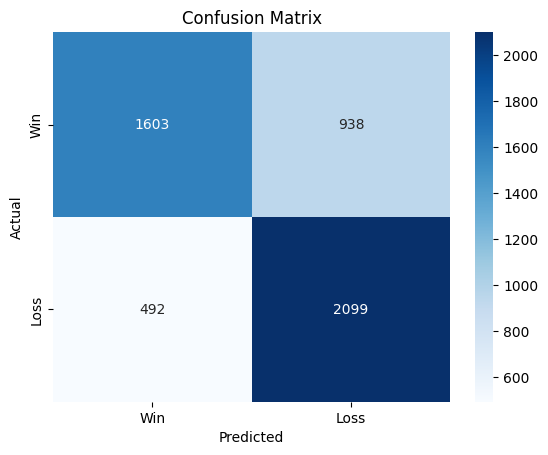

In [ ]:
from sklearn.metrics import accuracy_score
#Coded by Davin Stephens
# show accuracy on test set for neural network
y_pred = model.predict(X_test)
y_pred = [0 if val < 0.5 else 1 for val in y_pred]
nn_test_accuracy = accuracy_score(y_test, y_pred)
print("NN Test Accuracy: " + str(nn_test_accuracy))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# plot the confusion matrix
labels = ['Win', 'Loss']
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

# add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

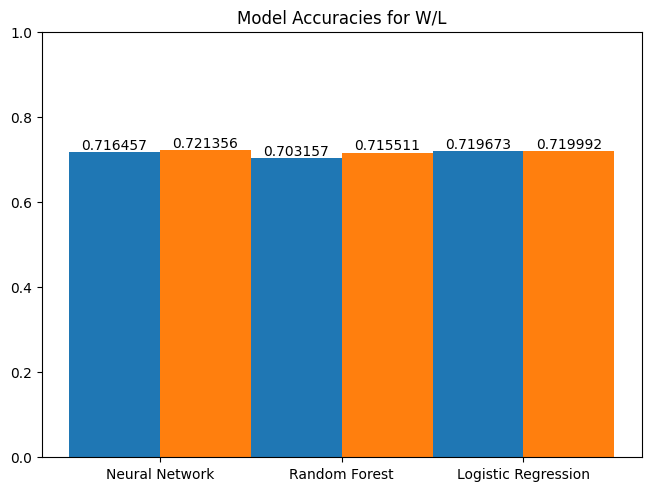

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Coded by Tyler Wulff
# Plot model accuracies showing train and test accuracies for each model
def plot_model_accuracies():

  # Models that will be plotted
  models = ("Neural Network", "Random Forest", "Logistic Regression")
  # Each model will plot the train and test accuracies that were calculated above
  accuracies = {
      'Train': (train_nn, forest_train, train_lR),
      'Test': (nn_test_accuracy, forest_test, test_lR)
  }

  x = np.arange(len(models))
  width = .5
  multiplier = 0
  fig, ax = plt.subplots(layout='constrained')

  # loop through the accuracies and add plot
  for attribute, measurement in accuracies.items():
      offset = width * multiplier
      rects = ax.bar(x + offset, measurement, width, label=attribute)
      ax.bar_label(rects)
      multiplier += 1

  # Set title and styles
  ax.set_title('Model Accuracies for W/L')
  ax.set_xticks([.25, 1.25, 2.25], models)
  ax.set_ylim(0, 1)
  plt.show()

#Blue bars represent training data, orange represnts testing accuracies
plot_model_accuracies()

# Spread Prediction

**Data pre-processing for spread prediction**

In [ ]:
import pandas as pd

#Coded by Davin Stephens
def spread_data():
  # access file from github
  nba_file = 'https://raw.githubusercontent.com/dcsteph7/Data-Capstone/main/nba_games1.csv'
  df = pd.read_csv(nba_file, index_col = 0)
  df = df.sort_values("date")
  df = df.reset_index(drop=True)

  #Calculate point difference
  df["point_difference"] = df["total_opp"] - df["total"]

  # remove duplicated stats and null values
  del df["mp.1"]
  del df["mp_opp.1"]
  del df["index_opp"]
  df["won"].value_counts()
  nulls = pd.isnull(df).sum()
  nulls = nulls[nulls > 0]
  valid_columns = df.columns[~df.columns.isin(nulls.index)]
  df = df[valid_columns].copy()

  # compute the rolling averages of the last 5 games played for each game
  team_stats = df.shift(periods = 1).groupby('team')[['fg', 'fga', '3p', '3pa', '3p_max', 'ft', 'fta', 'orb', 'drb', 'ast', 'stl', 'blk',
                                  'tov', 'fg_opp', 'fga_opp', '3p_opp', '3pa_opp', '3p_max_opp', 'ft_opp', 'fta_opp', 
                                  'orb_opp', 'drb_opp', 'ast_opp', 'stl_opp', 'blk_opp', 
                                  'tov_opp']].rolling(5, min_periods=1).mean().reset_index()
                                
  # merge rolling values with normal using the original index
  merged_df = df.merge(team_stats.reset_index()[['level_1', 'fg', 'fga', '3p', '3pa', '3p_max', 'ft', 'fta', 'orb', 'drb',
                                                'ast', 'stl', 'blk', 'tov', 'fg_opp', 'fga_opp', '3p_opp', '3pa_opp',
                                                '3p_max_opp', 'ft_opp', 'fta_opp', 'orb_opp', 'drb_opp', 'ast_opp',
                                                'stl_opp', 'blk_opp', 'tov_opp', 'team']], left_index=True, right_on='level_1', suffixes=('', '_r'))
  df2 = merged_df

  # calculate team ids if they are necessary (currently not in use)
  teams = list(set(df2['team'].values))
  teamToId = {t: i for i, t in enumerate(teams)}
  homeId = [teamToId[id] for id in list(df2['team'].values)]
  df2['home_id'] = homeId 
  awayId = [teamToId[id] for id in list(df2['team_opp'].values)]
  df2['away_id'] = awayId
  df2['won'] = df2['won'].apply(lambda x: 1 if x else 0)

  # set target and testing data
  target = df2['won']
  df2 = df2[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r', 'team', 'team_opp', 'date']]

  #Calculate the point difference to compare with the spread from sportsbooks
  df2['PointDifference'] = df['point_difference']
  count = 0
  for i in (df2.index):
    df2['PointDifference'][i] = df['point_difference'][count]
    count = count + 1
  return df2

df2 = spread_data()


<ipython-input-2-cfe6acb049fc>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['PointDifference'] = df['point_difference']
<ipython-input-2-cfe6acb049fc>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['PointDifference'][i] = df['point_difference'][count]


,home,fg_r,fga_r,3p_r,3pa_r,3p_max_r,ft_r,fta_r,orb_r,drb_r,...,orb_opp_r,drb_opp_r,ast_opp_r,stl_opp_r,blk_opp_r,tov_opp_r,team,team_opp,date,PointDifference
24810,1,32.0,90.0,8.0,32.0,2.0,12.0,20.0,18.0,21.0,...,18.0,36.0,22.0,7.0,5.0,20.0,CLE,WAS,2012-10-30,10
4262,0,36.0,79.0,7.0,20.0,3.0,15.0,22.0,18.0,36.0,...,18.0,21.0,26.0,11.0,10.0,12.0,DAL,LAL,2012-10-30,-10
5138,1,40.0,85.0,5.0,15.0,2.0,14.0,18.0,9.0,31.0,...,15.0,31.0,24.0,6.0,5.0,14.0,LAL,DAL,2012-10-30,-8
11223,0,38.0,77.0,3.0,13.0,1.0,12.0,31.0,15.0,31.0,...,9.0,31.0,22.0,9.0,5.0,11.0,BOS,MIA,2012-10-30,8
865,1,39.0,75.0,6.0,13.0,3.0,23.0,28.0,7.0,34.0,...,5.0,31.0,25.0,8.0,5.0,8.0,MIA,BOS,2012-10-30,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8583,1,39.8,86.2,15.6,40.2,6.6,13.2,16.2,10.8,32.8,...,9.0,32.0,25.8,6.6,6.0,12.8,BOS,GSW,2022-06-10,-10
1770,0,37.0,84.8,15.0,36.6,4.8,15.2,20.0,9.8,34.6,...,9.4,32.8,21.4,8.8,4.6,13.2,BOS,GSW,2022-06-13,10
1771,1,36.2,82.8,15.0,36.6,5.0,15.6,21.4,9.4,34.2,...,8.8,32.4,22.8,9.8,4.0,12.8,GSW,BOS,2022-06-13,10
8584,0,39.0,86.2,14.6,41.0,6.0,12.6,16.0,8.8,32.4,...,9.4,34.2,25.0,5.8,5.6,15.0,GSW,BOS,2022-06-16,-10


**Process spread data from Kaggle dataset**

In order to get odds from previous years, we had to use a kaggle dataset that had odds from the early 2000s to 2018. A lot of cleaning and data processing had to be completed, which is what the next few blocks of code consist of. (https://www.kaggle.com/datasets/ehallmar/nba-historical-stats-and-betting-data)

In [ ]:
#We had to pull multiple datasets from kaggle to find spreads over the last 10 years
#These data sets consisted of different game ids that had to be mapped to merge with other dataset
#Coded by Tyler Wulff

## this function maps the team ids with the team name
def team_ids():
    teams = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_teams_all.csv')
   
    team_dict = {}
    ##Loop through the dataframe and convert ids to names
    for i in range(len(teams.index)):
        if isinstance(teams['abbreviation'][i], str):
            team_dict[teams['team_id'][i]] = teams['abbreviation'][i]

    return team_dict

## This function maps the game ids to a date
def game_ids():
    teams = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    team_dict = {}
    #Loop through dataframe and convert ids to dates
    for i in range(len(teams.index)):
        if isinstance(teams['game_date'][i], str):
            team_dict[teams['game_id'][i]] = teams['game_date'][i]

    return team_dict

#Add spreads into dataframe using previous two functions to get spread using team name and date
def add_teams():
    moneylines = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_money_line.csv')
    over_under = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_totals.csv')
    spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_spread.csv')
    games = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    df = pd.DataFrame()
    temp_dict = team_ids()
    game_dict = game_ids()
    #Loop through spreads and add spread along with date, book name, and teams
    for i in range(len(spreads.index)):
        if (spreads['book_name'][i] == 'Pinnacle Sports'):
            temp = pd.DataFrame({"date":[game_dict[spreads['game_id'][i]]],
                            "book_name":[spreads['book_name'][i]],
                            "team":[temp_dict[spreads['team_id'][i]]],
                            "away_team": [temp_dict[spreads['a_team_id'][i]]],
                            "spread1": [spreads['spread1'][i]],
                            "spread2": [spreads['spread2'][i]]})
            #df = df.append(temp, ignore_index = True)
            df = pd.concat([df, temp])
    return df

#Add spreads using bovada sportsbook same as previous function
def add_teams_2():
    moneylines = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_money_line.csv')
    over_under = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_totals.csv')
    spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_spread.csv')
    games = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    df = pd.DataFrame()
    temp_dict = team_ids()
    game_dict = game_ids()
    #Loop through spreads and add spread along with date, book name, and teams
    for i in range(len(spreads.index)):
        if (spreads['book_name'][i] == 'Bovada'):
            temp = pd.DataFrame({"date":[game_dict[spreads['game_id'][i]]],
                            "book_name":[spreads['book_name'][i]],
                            "team":[temp_dict[spreads['team_id'][i]]],
                            "away_team": [temp_dict[spreads['a_team_id'][i]]],
                            "spread1": [spreads['spread1'][i]],
                            "spread2": [spreads['spread2'][i]]})
            #df = df.append(temp, ignore_index = True)
            df = pd.concat([df, temp])
    return df
        
prev_lines = add_teams()
prev_lines = prev_lines.reset_index(drop=True)
bovad_lines = add_teams_2()
bovad_lines = bovad_lines.reset_index(drop=True)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Read in previous data that holds spread information calculated above
yup = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/AllData.csv', index_col = 0)

#Will add bovada lines into dataframe that will be used with existing statistical information
## Coded by Austin Fett / Tyler Wulff
def get_box_score_average_data_3():

  # For future use, we will be pulling in all teams data
  team_list = ["Atl"]

  ind = 0
  Df = []
  Teams = []
  for team in team_list:

    # Initializing list of dicts
    rows = [{"Date": ''}, {"Spread_Result": ''}, {"O/U_Result": ''}, {"Team": ''}]
    # Initialize dataframes that will be used to hold features (statistical information)
    for i in df.index:
        d1 = {}
        rows.append(d1)
    
    result_found = []

    for i in yup.index:
      result_found.append(False)

    index = 0
    count = 0
    var = 0

    # Loop through dataframe
    for i in range(len(yup.index)):
          #Check if a line has not been added and if the date is in the kaggle dataset
          if (math.isnan(yup["Line"][i]) and yup["Date"][i] < '2018-11-06'):
                #Loop through the bovada lines and add line into dataframe
                # if it is the proper game
                for j in range(len(bovad_lines.index)):
                    if bovad_lines["date"][j] == yup["Date"][i]:
                          if bovad_lines["team"][j] == yup["Home_Team"][i] or bovad_lines["team"][j] == yup["Away_Team"][i]:
                              yup["Line"][i] = float(bovad_lines["spread1"][j])
                              Teams.append(bovad_lines["team"][j])
                              var = var + 1
                              break       
          count = count + 1    
    ind = ind + 1
    
    return yup, Teams

newLines = get_box_score_average_data_3()

In [ ]:
#Add dataframe into csv file with current bovada lines
one, two = newLines
one.to_csv('Spreads.csv')

In [ ]:
#Display game line information for presentation
game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Season_Odds.csv'
game_lines_2023_data = pd.read_csv(game_lines_2023_file)

In [ ]:
#Coded by Austin Fett/Tyler Wulff
#Add lines into previous dataframe using ESPN scraped line information 
game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Season_Odds.csv'
game_lines_2023_data = pd.read_csv(game_lines_2023_file)

#Subset dataframe to only include ESPN scraped games
yup2 = yup.loc[yup['Date'] > '2018-11-06']
#loop through dataframe
for i in range(len(yup.index)):
  #Check date to ensure it is in ESPN game range
  if yup['Date'][i] > '2018-11-06':
    #Loop through ESPN games
    for j in range(len(game_lines_2023_data)):
      #Find game based on date and teams and add line
      if game_lines_2023_data["Date"][j] == yup["Date"][i]:
        if game_lines_2023_data["Home"][j] == yup["Home_Team"][i]:
          yup['Line'][i] = game_lines_2023_data['Line'][j]
        if game_lines_2023_data["Away"][j] == yup["Away_Team"][i]:
          yup['Line'][i] = game_lines_2023_data['Line'][j] * -1

In [ ]:
#Coded by Tyler Wulff
#Read in previous csv file that contains several spreads
spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/Finally5.csv')
game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Season_Odds.csv'
game_lines_2023_data = pd.read_csv(game_lines_2023_file)
spreads['Date'] = pd.to_datetime(spreads['Date']).dt.date

#Loop through spreads dataframe
for i in range(len(spreads.index)):
  #Check dates to make sure we aren't looping unecessarily
  if str(spreads['Date'][i]) > '2018-10-01':
    #Loop through game lines data
    for j in range(len(game_lines_2023_data.index)):
      #Check dates and teams to ensure that lines are being added to the correct games
      if str(spreads['Date'][i]) == str(game_lines_2023_data['Date'][j]):
        if spreads['Team'][i] == game_lines_2023_data['Home'][j] or spreads['Team'][i] == game_lines_2023_data['Away'][j]:
          if game_lines_2023_data['Favorite'][j] == spreads['Team'][i]:
            spreads['Line'][i] = game_lines_2023_data['Line'][j]
            break
          else:
            spreads['Line'][i] = float(game_lines_2023_data['Line'][j]) * -1
            break

In [ ]:
spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/Finally5.csv')

In [ ]:
#Coded by Tyler Wulff
#combine spreads with box score statistical data and remove extra columns
spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/Finally5.csv')
spreads = spreads.drop(columns = ['Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])
spreads
df2 = df2.sort_index()
frames = [df2, spreads]
df3 = pd.concat(frames, axis=1)

In [ ]:
#Coded by Tyler Wulff
#Remove games that did not have a spread line available
df4 = df3[df3['Line'].notnull()]
df4 = df4.drop(columns = ['Date', 'Home_Team', 'Away_Team', 'Team'])

#Create a column to indicate whether a team covered or not
df4['Covered'] = df4['PointDifference']
df4 = df4.reset_index()
#Loop through games and give team a 1 if they covered the spread and a 0 if they did not
for i in range(len(df4.index)):
  if (df4['Line'][i] > 0):
    if (df4['PointDifference'][i] < df4['Line'][i]):
      df4['Covered'][i] = 1
    else:
      df4['Covered'][i] = 0
  if (df4['Line'][i] < 0):
    if (df4['PointDifference'][i] < df4['Line'][i]):
      df4['Covered'][i] = 1
    else:
      df4['Covered'][i] = 0
  if df4['Line'][i] == 0:
    if (df4['PointDifference'][i] > 0):
      df4['Covered'][i] = 0
    else:
      df4['Covered'][i] = 1


<ipython-input-24-d6188e1dcba2>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Covered'][i] = 0
<ipython-input-24-d6188e1dcba2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Covered'][i] = 1
<ipython-input-24-d6188e1dcba2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Covered'][i] = 0
<ipython-input-24-d6188e1dcba2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame


In [ ]:
#Display for presentation
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')

temp = df4[['PointDifference','home', 'team', 'team_opp', 'date']]
df4 = df4.drop(columns=['PointDifference','home', 'team', 'team_opp', 'date'])
df4 = df4.shift(periods=1)
df4['PointDifference'] = temp['PointDifference']
df4['home'] = temp['home']
df4['team'] = temp['team']
df4['team_opp'] = temp['team_opp']
df4['date'] = temp['date']
df4 = df4.drop([0])

Logistic Regression for spreads (last 5 game averages)

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#Coded by Tyler Wulff
# set target, testing and training data
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
target = df4[['date', 'Covered']]
df4 = df4[['date', 'home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r', 'Line']]
# normalize and split data into training and testing
# Testing set will be the 2021-2022 season
X_train = df4[df4["date"] < '2021-10-10']
X_test = df4[df4["date"] > '2021-10-09']
y_train = target[target["date"] < '2021-10-10']
y_test = target[target["date"] > '2021-10-09']

#Drop date column from test and train data
y_test = y_test.drop(columns=['date'])
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])
y_train = y_train.drop(columns=['date'])
xx_train = tf.keras.utils.normalize(X_train, axis=1)

#Initialize and fit logistic regression
logis = LogisticRegression(C=10.0, penalty='l1', solver='liblinear', max_iter=2000)
logis.fit(xx_train, y_train.values.ravel())

# Predict on training data
train_pred = logis.predict(X_train)

# Predict on testing data 
y_pred = logis.predict(X_test)

# Print accuracy score
print("Logistic Regression Train Accuracy: " + str(accuracy_score(y_train, train_pred)))
print("Logistic Regression Test Accuracy: " + str(accuracy_score(y_test, y_pred)))


Logistic Regression Train Accuracy: 0.695466313444518
Logistic Regression Test Accuracy: 0.6163757273482959


In [ ]:
import pandas as pd
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')


# Neural Network (Spreads)

**Neural Network for predicting spreads**

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
#Coded by Davin Stephens
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
#Covered is the target label to predict
target = df4['Covered']
#Features that will be predicted
df4 = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]
sentiment = 0

# normalize and split data into training and testing
xx_train = tf.keras.utils.normalize(df4, axis=1)
X_train, X_test, y_train, y_test = train_test_split(xx_train, target, test_size=.2)

# neural network model, not fully optimized yet 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
476/476 [==============================] - 2s 2ms/step - loss: 0.6894 - accuracy: 0.5369
Epoch 2/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6843 - accuracy: 0.5498
Epoch 3/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6680 - accuracy: 0.5933
Epoch 4/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6477 - accuracy: 0.6175
Epoch 5/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6372 - accuracy: 0.6327
Epoch 6/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6344 - accuracy: 0.6325
Epoch 7/50
476/476 [==============================] - 1s 3ms/step - loss: 0.6320 - accuracy: 0.6414
Epoch 8/50
476/476 [==============================] - 1s 3ms/step - loss: 0.6326 - accuracy: 0.6357
Epoch 9/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6311 - accuracy: 0.6377
Epoch 10/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6303 - accuracy: 0.6390

In [ ]:
#Prediction on the test set from the neural network on the spreads
y_pred = model.predict(X_test)
y_pred = [0 if val < 0.5 else 1 for val in y_pred]
nn_test_accuracy = accuracy_score(y_test, y_pred)
print(nn_test_accuracy)

119/119 [==============================] - 0s 1ms/step
0.6352879305811202


In [ ]:
import pandas as pd
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')

Linear Regression on predicting spreads

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023Season.csv')
# Coded by Tyler Wulff
def run_linear_regression():
  # Initialize train and test sets
  # x_train, y_train, x_test, y_test = regression_train_test_data()

  y_train = df4[['Line']]
  
  x_train = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]
  # normalize and split data into training and testing
  # Testing set will be the 2021-2022 season
  y_test = df5[['Line']]
  x_test = df5[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]

  #initialize and fit linear regression on training data
  lin_reg = LinearRegression()
  lin_reg.fit(x_train, y_train)

  #Predict with training set
  trainPrediction = lin_reg.predict(x_train)
  train_lin_mse = mean_squared_error(y_train, trainPrediction)
  train_lin_rmse = np.sqrt(train_lin_mse)
  print("Linear Regression Train Data RMSE: " + str(train_lin_rmse))

  #Predict with test data
  prediction = lin_reg.predict(x_test)
  # Find Mean squared error for prediction
  lin_mse = mean_squared_error(y_test, prediction)
  # Find RMSE
  lin_rmse = np.sqrt(lin_mse)
  print("Linear Regression Test Data RMSE: " + str(lin_rmse))
  return prediction, y_test, x_test

val, test, xTest = run_linear_regression()


Linear Regression Train Data RMSE: 6.669061946456832
Linear Regression Test Data RMSE: 6.217489537424567


Random Forest to predict spreads

In [ ]:
from sklearn.ensemble import RandomForestRegressor

df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023Season.csv')
def run_forest_regressor():
  #Initialize train and test data
  y_train = df4[['PointDifference']]
  x_train = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r', 'Line']]
  # normalize and split data into training and testing
  # Testing set will be the 2021-2022 season
  y_test = df5[['PointDifference']]
  x_test = df5[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r', 'Line']]

  #Initialize random forest regressor and fit on training data
  forestReg = RandomForestRegressor()
  forestReg.fit(x_train, y_train.values.ravel())

  #Predict using training data
  predict = forestReg.predict(x_train)

  #Find MSE and RMSE
  tree_mse = mean_squared_error(y_train, predict)
  tree_rmse = np.sqrt(tree_mse)

  #Predict using testing data
  test_predict = forestReg.predict(x_test)

  #Find MSE and RMSE
  test_tree_mse = mean_squared_error(y_test, test_predict)
  test_tree_rmse = np.sqrt(test_tree_mse)
  print("Random Forest Train Data RMSE: " + str(tree_rmse))
  print("Random Forest Test Data RMSE: " + str(test_tree_rmse))
  return test_predict, y_test

val, test = run_forest_regressor()
win = 0
loss = 0
total = 0
for i in range(len(val)):
  if (abs(val[i] - test['PointDifference'][i]) > 3):
    if (val[i] < test['PointDifference'][i]):
      win = win + 1
    else:
      loss = loss + 1
    total = total + 1
print(win)
print(loss)
print(total)
print(win/total)

Random Forest Train Data RMSE: 4.463324551033339
Random Forest Test Data RMSE: 11.86160597977968
955
963
1918
0.49791449426485923


Neural Network to predict spreads (regression)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
#Coded by Davin Stephens
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
#Covered is the target label to predict
target = df4['PointDifference']
#Features that will be predicted
df4 = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]

# normalize and split data into training and testing
xx_train = tf.keras.utils.normalize(df4, axis=1)
X_train, X_test, y_train, y_test = train_test_split(xx_train, target, test_size=.2)

# neural network model, not fully optimized yet 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam', loss='mae', metrics='mae')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
476/476 [==============================] - 4s 4ms/step - loss: 11.3753 - mae: 11.3753
Epoch 2/50
476/476 [==============================] - 1s 3ms/step - loss: 11.3486 - mae: 11.3486
Epoch 3/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2769 - mae: 11.2769
Epoch 4/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2358 - mae: 11.2358
Epoch 5/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2206 - mae: 11.2206
Epoch 6/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2124 - mae: 11.2124
Epoch 7/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2093 - mae: 11.2093
Epoch 8/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2048 - mae: 11.2048
Epoch 9/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2019 - mae: 11.2019
Epoch 10/50
476/476 [==============================] - 1s 2ms/step - loss: 11.2050 - mae: 11.2050
Epoch 11/50
476/476 [========

2023 Season Results

Below are the model results from the 2023 season, training on all of the previous data that has been cleaned and processed. 

Neural Network for 2023 season results

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Coded by Davin Stephens/Tyler Wulff
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023Season.csv')

y_train = df4[['Covered']]
X_train = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]
y_test = df5[['Covered']]
X_test = df5[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]


# neural network model, not fully optimized yet 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu6))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model.fit(X_train, y_train, epochs=50, batch_size=32)

#Prediction on the test set from the neural network on the spreads
y_pred = model.predict(X_test)
y_pred = [0 if val < 0.5 else 1 for val in y_pred]
nn_test_accuracy = accuracy_score(y_test, y_pred)
print(nn_test_accuracy)

Epoch 1/50
595/595 [==============================] - 7s 7ms/step - loss: 0.6698 - accuracy: 0.5872
Epoch 2/50
595/595 [==============================] - 4s 6ms/step - loss: 0.6542 - accuracy: 0.6155
Epoch 3/50
595/595 [==============================] - 2s 4ms/step - loss: 0.6474 - accuracy: 0.6202
Epoch 4/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6443 - accuracy: 0.6261
Epoch 5/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6396 - accuracy: 0.6319
Epoch 6/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6378 - accuracy: 0.6335
Epoch 7/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6372 - accuracy: 0.6317
Epoch 8/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6360 - accuracy: 0.6331
Epoch 9/50
595/595 [==============================] - 1s 2ms/step - loss: 0.6372 - accuracy: 0.6322
Epoch 10/50
595/595 [==============================] - 2s 3ms/step - loss: 0.6344 - accuracy: 0.6367

In [ ]:
#Coded by Tyler Wulff

#This loops through our neural network model predictions 
#and outputs what the profit for the 2023 season would have been if 
#a bettor placed a 10 dollar wager on every game, assuming all odds were -110
count = 0
win = 0
profit = 0
profitArr = []

for i in y_test.index:
  if y_test['Covered'][i] == y_pred[count]:
    win = win + 1
    profit = profit + 9.09
    
  else:
    profit = profit - 10

  profitArr.append(profit)
  count = count + 1

print(win)
print(count)

print(win / count)
print(profit)

1362
2374
0.573715248525695
2260.579999999978


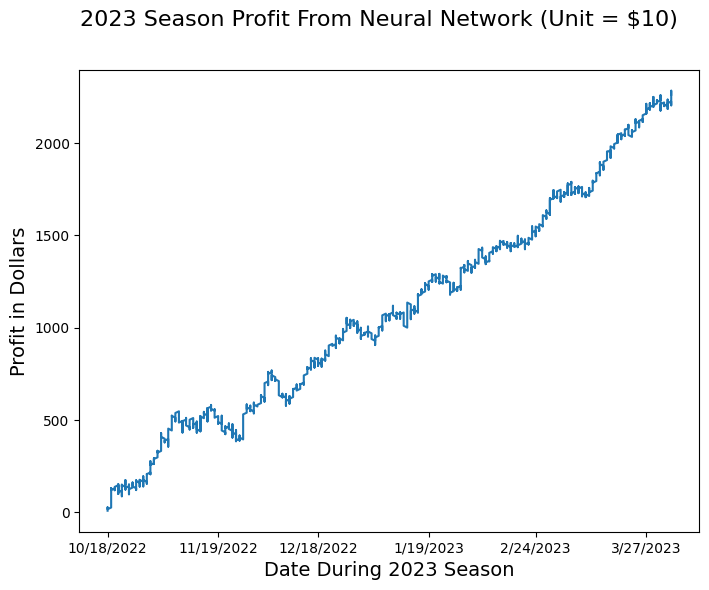

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Coded by Tyler Wulff
#This is a plot of our profit over the 2023 season
# https://www.python-graph-gallery.com/basic-time-series-with-matplotlib
fig, ax = plt.subplots(figsize=(8, 6))
half_year_locator = mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(half_year_locator)

fig.suptitle('2023 Season Profit From Neural Network (Unit = $10)', fontsize=16)
plt.xlabel('Date During 2023 Season', fontsize=14)
plt.ylabel('Profit in Dollars', fontsize=14)
ax.plot(df5['date'], profitArr);
fig.savefig('NNProfit.jpg')


In [ ]:
from xgboost import XGBClassifier

# Coded by Tyler Wulff
#XGBoost to check feature importance 
# Training data will be from 2010-2018 and test data will be from the 2023 season
df4 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023Season.csv')

y_train = df4[['Covered']]
X_train = df4[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]
y_test = df5[['Covered']]
X_test = df5[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracy

0.573715248525695

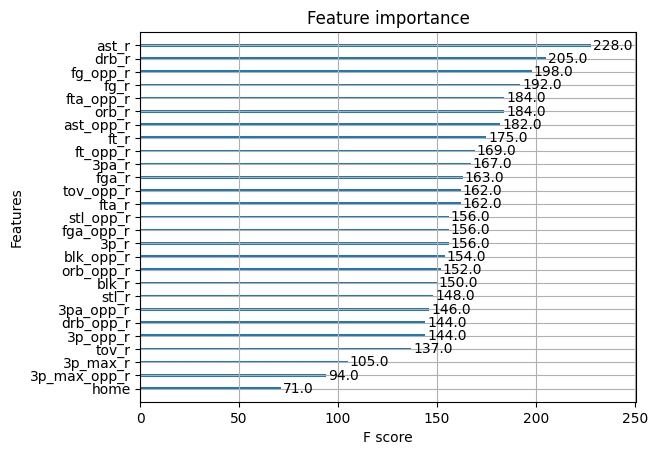

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
#Coded by Tyler Wulff
#Plot the feature importance
plot_importance(model)
plt.show()

# O/U Prediction

In [ ]:
import pandas as pd

#Coded by Davin Stephens
def spread_data():
  # access file from github
  nba_file = 'https://raw.githubusercontent.com/dcsteph7/Data-Capstone/main/nba_games1.csv'
  df = pd.read_csv(nba_file, index_col = 0)
  df = df.sort_values("date")
  df = df.reset_index(drop=True)

  #Calculate point difference
  df["point_total"] = df["total_opp"] + df["total"]

  return df

dF2 = spread_data()
dF2

,mp,mp.1,fg,fga,fg%,3p,3pa,3p%,ft,fta,...,usg%_max_opp,ortg_max_opp,drtg_max_opp,team_opp,total_opp,home_opp,season,date,won,point_total
0,240.0,240.0,32.0,90.0,0.356,8.0,32.0,0.250,12.0,20.0,...,33.5,164.0,108.0,CLE,94,1,2013,2012-10-30,False,178
1,240.0,240.0,36.0,79.0,0.456,7.0,20.0,0.350,15.0,22.0,...,33.6,149.0,118.0,WAS,84,0,2013,2012-10-30,True,178
2,240.0,240.0,40.0,85.0,0.471,5.0,15.0,0.333,14.0,18.0,...,31.0,140.0,114.0,LAL,91,1,2013,2012-10-30,True,190
3,240.0,240.0,38.0,77.0,0.494,3.0,13.0,0.231,12.0,31.0,...,24.5,146.0,108.0,DAL,99,0,2013,2012-10-30,False,190
4,240.0,240.0,39.0,75.0,0.520,6.0,13.0,0.462,23.0,28.0,...,41.7,219.0,121.0,MIA,120,1,2013,2012-10-30,False,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25653,240.0,240.0,34.0,85.0,0.400,15.0,38.0,0.395,14.0,19.0,...,36.3,133.0,112.0,GSW,107,0,2022,2022-06-10,False,204
25654,240.0,240.0,31.0,75.0,0.413,11.0,32.0,0.344,21.0,31.0,...,36.2,222.0,107.0,GSW,104,1,2022,2022-06-13,False,198
25655,240.0,240.0,41.0,88.0,0.466,9.0,40.0,0.225,13.0,15.0,...,94.4,300.0,112.0,BOS,94,0,2022,2022-06-13,True,198
25656,240.0,240.0,38.0,92.0,0.413,19.0,46.0,0.413,8.0,8.0,...,42.6,141.0,126.0,BOS,90,1,2022,2022-06-16,True,193


In [ ]:
#We had to pull multiple datasets from kaggle to find spreads over the last 10 years
#These data sets consisted of different game ids that had to be mapped to merge with other dataset
#Coded by Tyler Wulff

## this function maps the team ids with the team name
def team_ids():
    teams = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_teams_all.csv')
   
    team_dict = {}
    ##Loop through the dataframe and convert ids to names
    for i in range(len(teams.index)):
        if isinstance(teams['abbreviation'][i], str):
            team_dict[teams['team_id'][i]] = teams['abbreviation'][i]

    return team_dict

## This function maps the game ids to a date
def game_ids():
    teams = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    team_dict = {}
    #Loop through dataframe and convert ids to dates
    for i in range(len(teams.index)):
        if isinstance(teams['game_date'][i], str):
            team_dict[teams['game_id'][i]] = teams['game_date'][i]

    return team_dict

#Add spreads into dataframe using previous two functions to get spread using team name and date
def add_teams():
    moneylines = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_money_line.csv')
    over_under = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_totals.csv')
    spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_spread.csv')
    games = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    df = pd.DataFrame()
    temp_dict = team_ids()
    game_dict = game_ids()
    #Loop through spreads and add spread along with date, book name, and teams
    for i in range(len(over_under.index)):
        if (over_under['book_name'][i] == 'Pinnacle Sports'):
            temp = pd.DataFrame({"date":[game_dict[over_under['game_id'][i]]],
                            "book_name":[over_under['book_name'][i]],
                            "team":[temp_dict[over_under['team_id'][i]]],
                            "away_team": [temp_dict[over_under['a_team_id'][i]]],
                            "total1": [over_under['total1'][i]],
                            "total2": [over_under['total2'][i]]})
            #df = df.append(temp, ignore_index = True)
            df = pd.concat([df, temp])
    return df

#Add spreads using bovada sportsbook same as previous function
def add_teams_2():
    moneylines = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_money_line.csv')
    over_under = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_totals.csv')
    spreads = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_betting_spread.csv')
    games = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/nba_games_all.csv')
    
    df = pd.DataFrame()
    temp_dict = team_ids()
    game_dict = game_ids()
    #Loop through spreads and add spread along with date, book name, and teams
    for i in range(len(over_under.index)):
        if (over_under['book_name'][i] == 'Bovada'):
            temp = pd.DataFrame({"date":[game_dict[over_under['game_id'][i]]],
                            "book_name":[over_under['book_name'][i]],
                            "team":[temp_dict[over_under['team_id'][i]]],
                            "away_team": [temp_dict[over_under['a_team_id'][i]]],
                            "total1": [over_under['total1'][i]],
                            "total2": [over_under['total2'][i]]})
            #df = df.append(temp, ignore_index = True)
            df = pd.concat([df, temp])
    return df
        
prev_lines = add_teams()
prev_lines = prev_lines.reset_index(drop=True)
bovad_lines = add_teams_2()
bovad_lines = bovad_lines.reset_index(drop=True)
bovad_lines

,date,book_name,team,away_team,total1,total2
0,2012-01-09,Bovada,NOP,DEN,192.0,192.0
1,2012-01-10,Bovada,OKC,MEM,193.0,193.0
2,2012-01-11,Bovada,OKC,NOP,184.0,184.0
3,2012-01-11,Bovada,HOU,SAS,199.0,199.0
4,2012-01-11,Bovada,ORL,POR,185.0,185.0
...,...,...,...,...,...,...
14537,2018-05-03,Bovada,PHI,BOS,207.0,207.0
14538,2018-05-04,Bovada,GSW,NOP,233.0,233.0
14539,2018-05-05,Bovada,BOS,PHI,207.0,207.0
14540,2018-05-06,Bovada,GSW,NOP,231.0,231.0


In [ ]:
#Display game line information for presentation
game_lines_2023_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Season_Odds.csv'
game_lines_2023_data = pd.read_csv(game_lines_2023_file)
game_lines_2023_data

,Unnamed: 0,Date,Away,Home,Favorite,Line,Over/Under
0,0,2020-12-22,GSW,BKN,BKN,-7.0,235.0
1,1,2020-12-22,LAC,LAL,LAL,-2.0,219.5
2,2,2020-12-23,CHA,CLE,CHA,-3.0,217.0
3,3,2020-12-23,NYK,IND,IND,-7.5,215.5
4,4,2020-12-23,MIA,ORL,MIA,-4.5,218.0
...,...,...,...,...,...,...,...
3212,917,2023-02-27,DET,CHA,CHA,-7.0,233.5
3213,918,2023-02-27,MIA,PHI,PHI,-5.5,217.0
3214,919,2023-02-27,BOS,NYK,BOS,-2.0,224.5
3215,920,2023-02-27,ORL,NOP,NOP,-5.0,229.5


In [ ]:
working_spreads_file = 'https://raw.githubusercontent.com/austinfett/ML-Capstone/main/WorkingSpreads.csv'
working_spreads_data = pd.read_csv(working_spreads_file)
working_spreads_data['O/U_Line'] = 0

for i in range(len(working_spreads_data.index)):
  if working_spreads_data['date'][i] < '2018-11-06':
    for j in range(len(bovad_lines.index)):
      if working_spreads_data['date'][i] == bovad_lines['date'][j]:
        if working_spreads_data['team'][i] == bovad_lines['team'][j] or working_spreads_data['team'][i] == bovad_lines['away_team'][j]:
          working_spreads_data['O/U_Line'][i] = bovad_lines['total1'][j]
          break
  else:
    for j in range(len(game_lines_2023_data.index)):
      if working_spreads_data['date'][i] == game_lines_2023_data['Date'][j]:
        if working_spreads_data['team'][i] == game_lines_2023_data['Home'][j] or working_spreads_data['team'][i] == game_lines_2023_data['Away'][j]:
          working_spreads_data['O/U_Line'][i] = game_lines_2023_data['Over/Under'][j]
          break

working_spreads_data

<ipython-input-12-8020987f8fa8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_spreads_data['O/U_Line'][i] = bovad_lines['total1'][j]
<ipython-input-12-8020987f8fa8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_spreads_data['O/U_Line'][i] = game_lines_2023_data['Over/Under'][j]


,Unnamed: 0,index,home,fg_r,fga_r,3p_r,3pa_r,3p_max_r,ft_r,fta_r,...,tov_opp_r,team,team_opp,date,PointDifference,Spread_Result,Line,O/U_Result,Covered,O/U_Line
0,0,0,1,40.000000,85.0,7.000000,22.0,4.0,15.000000,17.000000,...,21.000000,ATL,HOU,2012-11-02,7,NaN,5.0,NaN,0,203
1,1,1,0,40.500000,84.0,7.500000,23.5,3.0,14.500000,18.500000,...,20.500000,ATL,OKC,2012-11-04,-9,NaN,9.0,NaN,1,199
2,2,2,1,39.666667,85.0,7.333333,23.0,3.0,11.666667,16.333333,...,18.666667,ATL,IND,2012-11-07,-3,NaN,4.0,NaN,1,192
3,3,3,1,38.250000,84.0,7.750000,23.5,3.0,11.750000,16.250000,...,17.500000,ATL,MIA,2012-11-09,6,NaN,-5.0,NaN,0,198
4,4,4,0,36.600000,81.6,8.000000,23.8,3.0,10.800000,16.200000,...,16.600000,ATL,LAC,2012-11-11,13,NaN,6.5,NaN,0,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,19010,25653,0,43.200000,85.4,12.000000,28.8,4.2,17.800000,21.400000,...,9.800000,WAS,BOS,2022-04-03,42,NaN,13.0,NaN,0,222.5
19011,19011,25654,0,45.600000,88.8,11.400000,29.2,3.6,15.400000,19.800000,...,9.600000,WAS,MIN,2022-04-05,-18,NaN,12.0,NaN,1,238.5
19012,19012,25655,0,46.400000,90.2,12.200000,31.0,4.0,14.800000,18.600000,...,9.200000,WAS,ATL,2022-04-06,15,NaN,10.5,NaN,0,235.0
19013,19013,25656,1,44.000000,85.6,11.400000,29.4,3.6,13.400000,16.800000,...,9.000000,WAS,NYK,2022-04-08,22,NaN,3.5,NaN,0,224.0


In [ ]:
working_spreads_data['Covered_O/U'] = 0

for i in range(len(working_spreads_data.index)):
  for j in range(len(dF2.index)):
    if working_spreads_data['date'][i] == dF2['date'][j]:
      if working_spreads_data['team'][i] == dF2['team'][j] or working_spreads_data['team'][i] == dF2['team_opp'][j]:
        working_spreads_data['O/U_Result'][i] = dF2['point_total'][j]
        if float(working_spreads_data['O/U_Result'][i]) > float(working_spreads_data['O/U_Line'][i]):
          working_spreads_data['Covered_O/U'][i] = 1
        elif float(working_spreads_data['O/U_Result'][i]) < float(working_spreads_data['O/U_Line'][i]):
          working_spreads_data['Covered_O/U'][i] = -1
        break

working_spreads_data

<ipython-input-15-47948f937c7b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_spreads_data['O/U_Result'][i] = dF2['point_total'][j]
<ipython-input-15-47948f937c7b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_spreads_data['Covered_O/U'][i] = 1
<ipython-input-15-47948f937c7b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_spreads_data['Covered_O/U'][i] = -1


,Unnamed: 0,index,home,fg_r,fga_r,3p_r,3pa_r,3p_max_r,ft_r,fta_r,...,team,team_opp,date,PointDifference,Spread_Result,Line,O/U_Result,Covered,O/U_Line,Covered_O/U
0,0,0,1,40.000000,85.0,7.000000,22.0,4.0,15.000000,17.000000,...,ATL,HOU,2012-11-02,7,NaN,5.0,211.0,0,203,1
1,1,1,0,40.500000,84.0,7.500000,23.5,3.0,14.500000,18.500000,...,ATL,OKC,2012-11-04,-9,NaN,9.0,199.0,1,199,0
2,2,2,1,39.666667,85.0,7.333333,23.0,3.0,11.666667,16.333333,...,ATL,IND,2012-11-07,-3,NaN,4.0,175.0,1,192,-1
3,3,3,1,38.250000,84.0,7.750000,23.5,3.0,11.750000,16.250000,...,ATL,MIA,2012-11-09,6,NaN,-5.0,184.0,0,198,-1
4,4,4,0,36.600000,81.6,8.000000,23.8,3.0,10.800000,16.200000,...,ATL,LAC,2012-11-11,13,NaN,6.5,165.0,0,195,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,19010,25653,0,43.200000,85.4,12.000000,28.8,4.2,17.800000,21.400000,...,WAS,BOS,2022-04-03,42,NaN,13.0,246.0,0,222.5,1
19011,19011,25654,0,45.600000,88.8,11.400000,29.2,3.6,15.400000,19.800000,...,WAS,MIN,2022-04-05,-18,NaN,12.0,246.0,1,238.5,1
19012,19012,25655,0,46.400000,90.2,12.200000,31.0,4.0,14.800000,18.600000,...,WAS,ATL,2022-04-06,15,NaN,10.5,221.0,0,235.0,-1
19013,19013,25656,1,44.000000,85.6,11.400000,29.4,3.6,13.400000,16.800000,...,WAS,NYK,2022-04-08,22,NaN,3.5,206.0,0,224.0,-1


In [ ]:
import numpy as np

working_spreads_data = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/working_spreads_all.csv')

for i in range(len(working_spreads_data.index)):
  if working_spreads_data['Covered_O/U'][i] != 0 and working_spreads_data['Covered_O/U'][i] != 1:
    print('gone')

# working_spreads_data.to_csv('working_spreads_all.csv')

In [ ]:
season_2023 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023Season.csv')
scores_2023 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2021_2023_Box_Scores.csv', on_bad_lines='skip')
odds_2023 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/2023_Season_Odds.csv')
season_2023['points'] = 0
season_2023['points_opp'] = 0
season_2023['O/U_Result'] = 0
season_2023['O/U_Line'] = 0

for i in range(len(season_2023.index)):
  found_1 = False
  found_2 = False
  month, day, year = season_2023['date'][i].split('/')
  date = '{}-{}-{}'.format(year, month, day)

  for j in range(len(scores_2023.index)):
    if date == scores_2023['Date'][j]:
      if season_2023['team'][i] == scores_2023['Opponent'][j]:
        season_2023['points_opp'][i] = scores_2023['Points'][j]
        found_1 = True
      elif season_2023['team_opp'][i] == scores_2023['Opponent'][j]:
        season_2023['points'][i] = scores_2023['Points'][j]
        found_2 = True

      if found_1 and found_2:
        season_2023['O/U_Result'][i] = season_2023['points'][i] + season_2023['points_opp'][i]
        break

  for j in range(len(odds_2023.index)):
    if date == odds_2023['Date'][j]:
      if season_2023['team'][i] == odds_2023['Away'][j] or season_2023['team'][i] == odds_2023['Home'][j]:
        season_2023['O/U_Line'][i] = odds_2023['Over/Under'][j]

season_2023.to_csv('2023_Season_All.csv')
season_2023

<ipython-input-46-8bfe777d7ec0>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_2023['points_opp'][i] = scores_2023['Points'][j]
<ipython-input-46-8bfe777d7ec0>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_2023['points'][i] = scores_2023['Points'][j]
<ipython-input-46-8bfe777d7ec0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_2023['O/U_Result'][i] = season_2023['points'][i] + season_2023['points_opp'][i

,Unnamed: 0.1,index,Unnamed: 0,home,fg_r,fga_r,3p_r,3pa_r,3p_max_r,ft_r,...,team,team_opp,date,PointDifference,Line,Covered,points,points_opp,O/U_Result,O/U_Line
0,0,0,1744,0,40.0,80.0,13.0,34.0,5.0,24.0,...,PHI,BOS,10/18/2022,9,3.0,0,117,126,243,216.0
1,1,1,79,1,46.0,82.0,12.0,35.0,4.0,22.0,...,BOS,PHI,10/18/2022,-9,-3.0,1,126,117,243,216.0
2,2,2,1031,0,40.0,94.0,10.0,40.0,3.0,19.0,...,LAL,GSW,10/18/2022,14,7.5,0,109,123,232,223.5
3,3,3,713,1,45.0,99.0,16.0,45.0,4.0,17.0,...,GSW,LAL,10/18/2022,-14,-7.5,1,123,109,232,223.5
4,4,4,2218,1,42.0,83.0,16.0,38.0,4.0,23.0,...,UTA,DEN,10/19/2022,-21,7.0,1,123,102,225,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369,2369,2369,236,1,41.4,87.4,12.4,34.0,4.4,18.0,...,BKN,MIN,4/4/2023,5,3.0,0,0,0,0,0.0
2370,2370,2370,1426,0,40.8,87.0,10.6,29.6,3.4,16.2,...,MIN,BKN,4/4/2023,-5,-3.0,1,0,0,0,0.0
2371,2371,2371,1346,0,47.4,92.2,14.2,36.6,4.0,17.2,...,MIL,WAS,4/4/2023,-12,-14.0,0,0,0,0,0.0
2372,2372,2372,872,1,43.4,94.4,10.4,30.4,5.0,19.4,...,HOU,DEN,4/4/2023,-21,11.5,1,0,0,0,0.0


In [ ]:
season_2023['Covered_O/U'] = 0

for i in range(len(season_2023.index)):
  if float(season_2023['O/U_Result'][i]) >= float(season_2023['O/U_Line'][i]):
    season_2023['Covered_O/U'][i] = 1
  else:
    season_2023['Covered_O/U'][i] = 0

season_2023.to_csv('2023_Season_All.csv')
season_2023

<ipython-input-47-9156ca9557b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_2023['Covered_O/U'][i] = 1
<ipython-input-47-9156ca9557b4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_2023['Covered_O/U'][i] = 0


,Unnamed: 0.1,index,Unnamed: 0,home,fg_r,fga_r,3p_r,3pa_r,3p_max_r,ft_r,...,team_opp,date,PointDifference,Line,Covered,points,points_opp,O/U_Result,O/U_Line,Covered_O/U
0,0,0,1744,0,40.0,80.0,13.0,34.0,5.0,24.0,...,BOS,10/18/2022,9,3.0,0,117,126,243,216.0,1
1,1,1,79,1,46.0,82.0,12.0,35.0,4.0,22.0,...,PHI,10/18/2022,-9,-3.0,1,126,117,243,216.0,1
2,2,2,1031,0,40.0,94.0,10.0,40.0,3.0,19.0,...,GSW,10/18/2022,14,7.5,0,109,123,232,223.5,1
3,3,3,713,1,45.0,99.0,16.0,45.0,4.0,17.0,...,LAL,10/18/2022,-14,-7.5,1,123,109,232,223.5,1
4,4,4,2218,1,42.0,83.0,16.0,38.0,4.0,23.0,...,DEN,10/19/2022,-21,7.0,1,123,102,225,225.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2369,2369,2369,236,1,41.4,87.4,12.4,34.0,4.4,18.0,...,MIN,4/4/2023,5,3.0,0,0,0,0,0.0,1
2370,2370,2370,1426,0,40.8,87.0,10.6,29.6,3.4,16.2,...,BKN,4/4/2023,-5,-3.0,1,0,0,0,0.0,1
2371,2371,2371,1346,0,47.4,92.2,14.2,36.6,4.0,17.2,...,WAS,4/4/2023,-12,-14.0,0,0,0,0,0.0,1
2372,2372,2372,872,1,43.4,94.4,10.4,30.4,5.0,19.4,...,DEN,4/4/2023,-21,11.5,1,0,0,0,0.0,1


# Neural Network (O/U)

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
#Coded by Davin Stephens
df8 = pd.read_csv('https://raw.githubusercontent.com/austinfett/ML-Capstone/main/working_spreads_all.csv')
#Covered is the target label to predict
target2 = df8['Covered_O/U']
#Features that will be predicted
df8 = df8[['home', 'fg_r', 'fga_r', '3p_r', '3pa_r', '3p_max_r', 'ft_r', 'fta_r', 'orb_r', 'drb_r', 'ast_r', 'stl_r', 'blk_r', 'tov_r', 'fg_opp_r', 'fga_opp_r', '3p_opp_r', '3pa_opp_r', '3p_max_opp_r', 'ft_opp_r', 'fta_opp_r', 'orb_opp_r', 'drb_opp_r', 'ast_opp_r', 'stl_opp_r', 'blk_opp_r', 'tov_opp_r']]

# normalize and split data into training and testing
xx_train2 = tf.keras.utils.normalize(df8, axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(xx_train2, target2, test_size=.2)

# neural network model, not fully optimized yet 
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Dense(64, activation=tf.nn.relu6))
model2.add(tf.keras.layers.Dense(32, activation=tf.nn.relu6))
model2.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
model2.fit(X_train2, y_train2, epochs=50, batch_size=32)

Epoch 1/50
476/476 [==============================] - 2s 2ms/step - loss: 0.6875 - accuracy: 0.5543
Epoch 2/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6863 - accuracy: 0.5560
Epoch 3/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6855 - accuracy: 0.5571
Epoch 4/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6833 - accuracy: 0.5606
Epoch 5/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6774 - accuracy: 0.5726
Epoch 6/50
476/476 [==============================] - 2s 3ms/step - loss: 0.6731 - accuracy: 0.5835
Epoch 7/50
476/476 [==============================] - 1s 3ms/step - loss: 0.6694 - accuracy: 0.5866
Epoch 8/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6691 - accuracy: 0.5884
Epoch 9/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6690 - accuracy: 0.5843
Epoch 10/50
476/476 [==============================] - 1s 2ms/step - loss: 0.6683 - accuracy: 0.5884

In [ ]:
from sklearn.metrics import accuracy_score

#Prediction on the test set from the neural network on the spreads
y_pred2 = model2.predict(X_test2)
y_pred2 = [0 if val < 0.5 else 1 for val in y_pred2]
nn_test_accuracy2 = accuracy_score(y_test2, y_pred2)
print(nn_test_accuracy2)

119/119 [==============================] - 0s 1ms/step
0.6224033657638707
